In [1]:
%matplotlib inline

# Radial velocity fitting

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.0


In this tutorial, we will demonstrate how to fit radial velocity observations of an exoplanetary system using *exoplanet*.
We will follow [the getting started tutorial](https://radvel.readthedocs.io/en/latest/tutorials/K2-24_Fitting+MCMC.html) from [the exellent RadVel package](https://radvel.readthedocs.io) where they fit for the parameters of the two planets in [the K2-24 system](https://arxiv.org/abs/1511.04497).

First, let's download the data from RadVel:

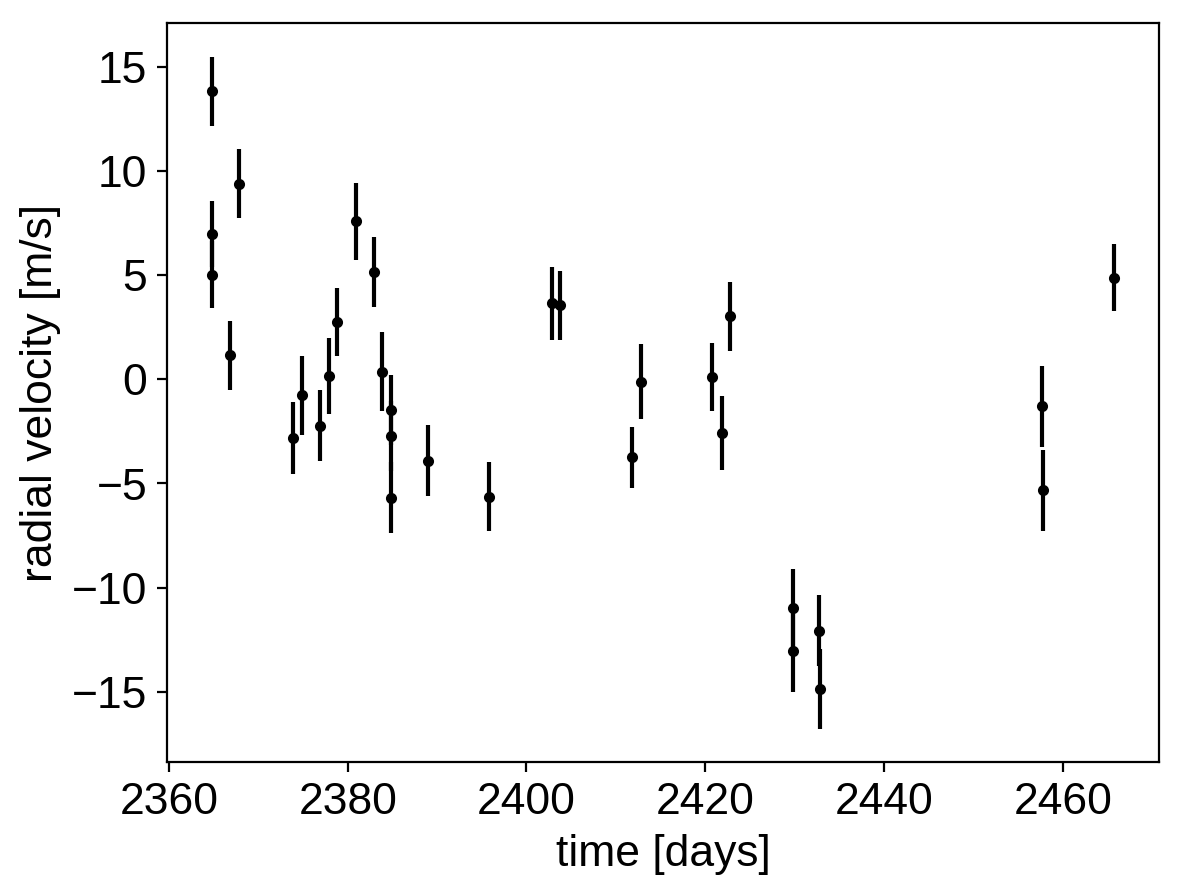

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

x = np.array(data.t)
y = np.array(data.vel)
yerr = np.array(data.errvel)

plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

Now, we know the periods and transit times for the planets [from the K2 light curve](https://arxiv.org/abs/1511.04497), so let's start by using the :func:`exoplanet.estimate_semi_amplitude` function to estimate the expected RV semi-amplitudes for the planets.

In [4]:
import exoplanet as xo

periods = [20.8851, 42.3633]
period_errs = [0.0003, 0.0006]
t0s = [2072.7948, 2082.6251]
t0_errs = [0.0007, 0.0004]
Ks = xo.estimate_semi_amplitude(periods, x, y, yerr, t0s=t0s)
print(Ks, "m/s")

[5.05069163 5.50983542] m/s


## The radial velocity model in PyMC3

Now that we have the data and an estimate of the initial values for the parameters, let's start defining the probabilistic model in PyMC3 (take a look at :ref:`intro-to-pymc3` if you're new to PyMC3).
First, we'll define our priors on the parameters:

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
        
    # Gaussian priors based on transit data (from Petigura et al.)
    t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs), shape=2)
    P = pm.Normal("P", mu=np.array(periods), sd=np.array(period_errs), shape=2)

    # Wide log-normal prior for semi-amplitude
    logK = pm.Normal("logK", mu=np.log(Ks), sd=10.0, shape=2)
    
    # This is a sanity check that restricts the semiamplitude to reasonable
    # values because things can get ugly as K -> 0
    pm.Potential("logK_bound", tt.switch(logK < 0, -np.inf, 0.0))
    
    # We also want to keep period physical but this probably won't be hit
    pm.Potential("P_bound", tt.switch(P <= 0, -np.inf, 0.0))

    # Eccentricity & argument of periasteron
    ecc = pm.Beta("ecc", alpha=0.867, beta=3.03, shape=2,
                  testval=np.array([0.1, 0.1]))
    omega = xo.distributions.Angle("omega", shape=2)
    
    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)

Now we'll define the orbit model:

In [6]:
with model:
    
    # Set up the orbit
    orbit = xo.orbits.KeplerianOrbit(
        period=P, t0=t0,
        ecc=ecc, omega=omega)
    
    # Set up the RV model and save it as a deterministic
    # for plotting purposes later
    vrad = orbit.get_radial_velocity(x, K=tt.exp(logK))
    pm.Deterministic("vrad", vrad)
    
    # Define the background model
    A = np.vander(x - 0.5*(x.min() + x.max()), 3)
    bkg = pm.Deterministic("bkg", tt.dot(A, trend))
    
    # Sum over planets and add the background to get the full model
    rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)

For plotting purposes, it can be useful to also save the model on a fine grid in time.

In [7]:
t = np.linspace(x.min()-5, x.max()+5, 1000)

with model:
    vrad_pred = orbit.get_radial_velocity(t, K=tt.exp(logK))
    pm.Deterministic("vrad_pred", vrad_pred)
    A_pred = np.vander(t - 0.5*(x.min() + x.max()), 3)
    bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
    rv_model_pred = pm.Deterministic("rv_model_pred",
                                     tt.sum(vrad_pred, axis=-1) + bkg_pred)

Now, we can plot the initial model:

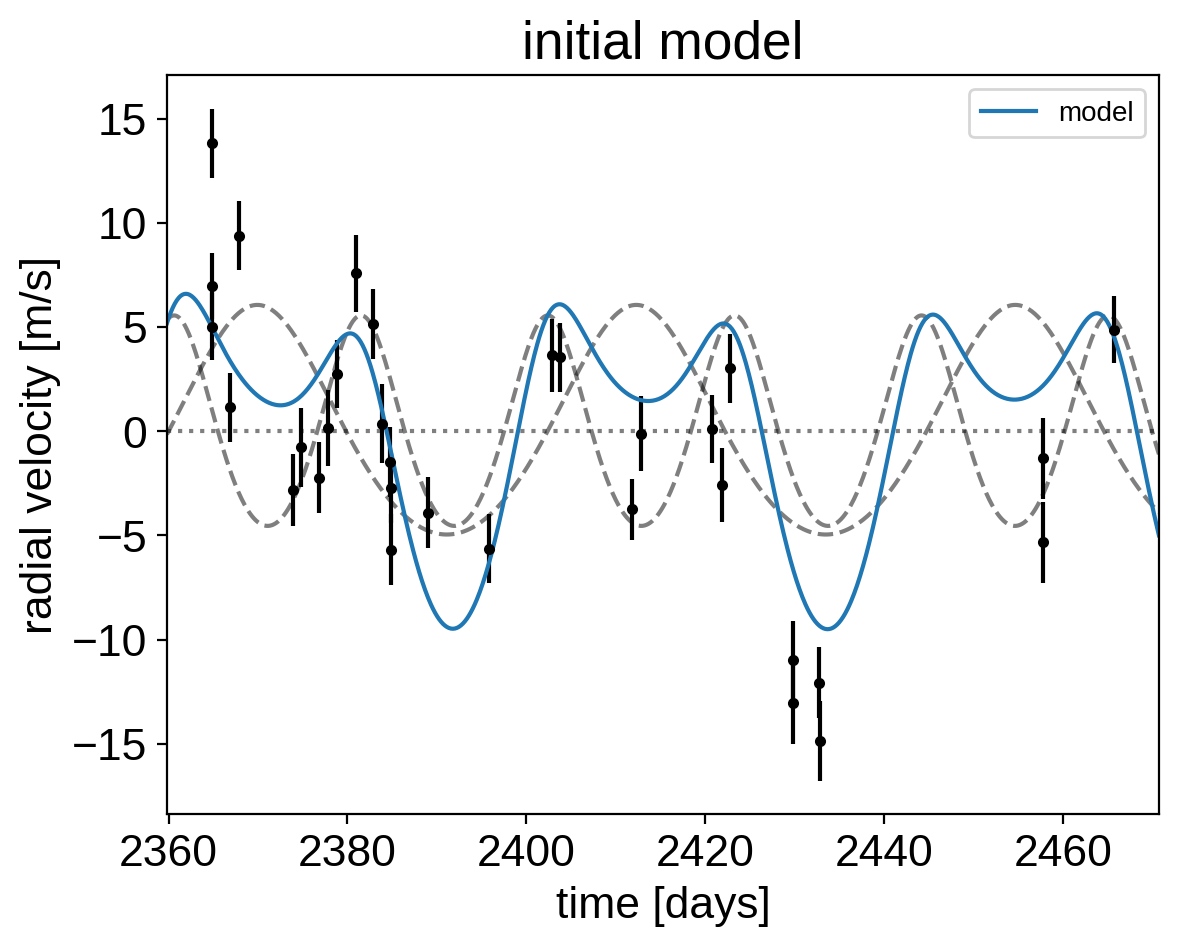

In [8]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

with model:
    plt.plot(t, xo.eval_in_model(vrad_pred), "--k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(bkg_pred), ":k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("initial model");

In this plot, the background is the dotted line, the individual planets are the dashed lines, and the full model is the blue line.

It doesn't look amazing so let's add in the likelihood and fit for the maximum a posterior parameters.

In [9]:
with model:
    
    err = tt.sqrt(yerr**2 + tt.exp(2*logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)
    
    map_soln = xo.optimize(start=model.test_point, vars=[trend])
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: ['trend']


message: Optimization terminated successfully.
logp: -85.64878196427782 -> -70.76432173140468


optimizing logp for variables: ['trend', 'logs', 'omega_angle__', 'ecc_logodds__', 'logK', 'P', 't0']


message: Desired error not necessarily achieved due to precision loss.
logp: -70.76432173140468 -> -21.515004321664


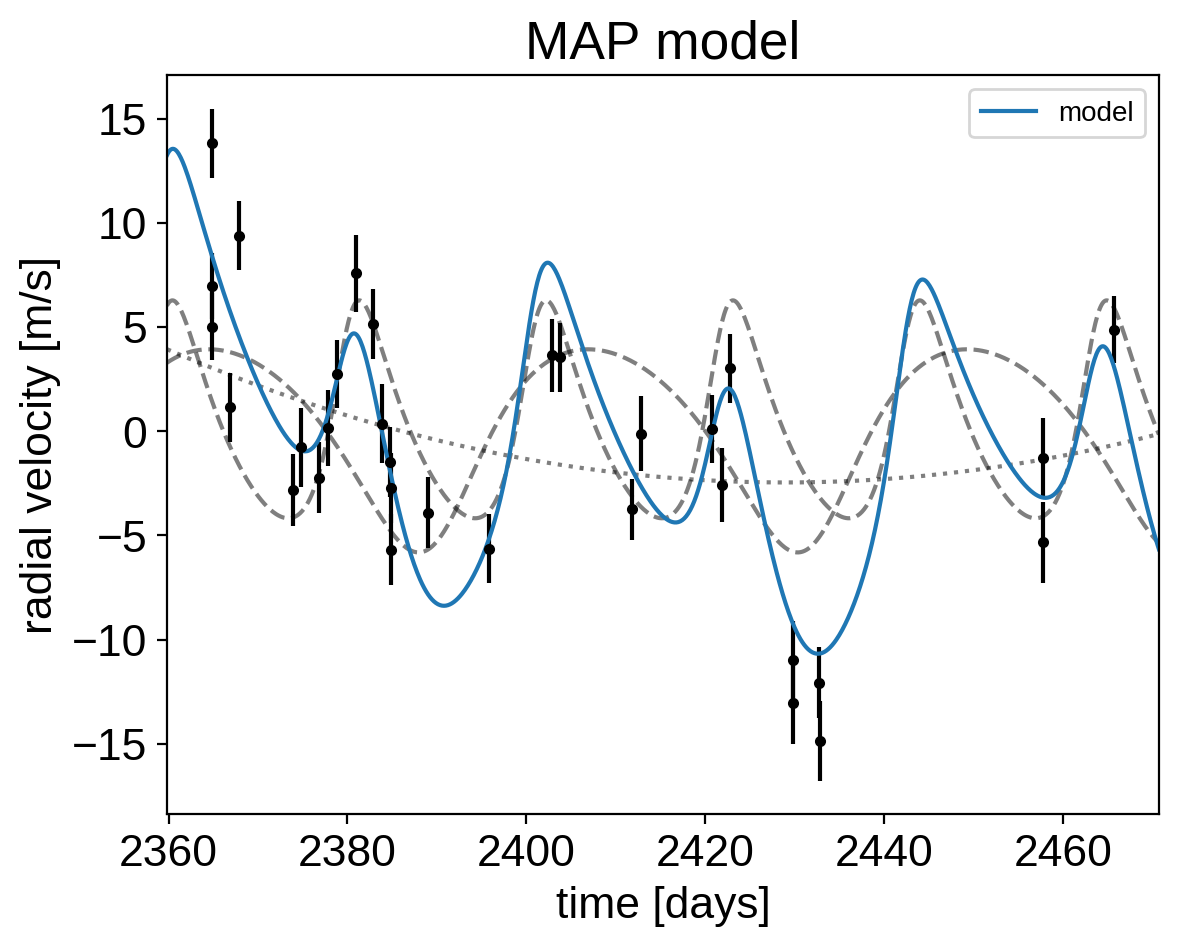

In [10]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
plt.plot(t, map_soln["bkg_pred"], ":k", alpha=0.5)
plt.plot(t, map_soln["rv_model_pred"], label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("MAP model");

That looks better.

## Sampling

Now that we have our model set up and a good estimate of the initial parameters, let's start sampling.
There are substantial covariances between some of the parameters so we'll use a :class:`exoplanet.PyMC3Sampler` to tune the sampler (see the :ref:`pymc3-extras` tutorial for more information).

In [11]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(start=200, window=100, finish=300)
with model:
    burnin = sampler.tune(tune=4000, start=model.test_point,
                          step_kwargs=dict(target_accept=0.95))
    trace = sampler.sample(draws=4000)

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 20/808 [00:00<00:03, 197.68draws/s]

Sampling 4 chains:   3%|▎         | 27/808 [00:00<00:06, 126.48draws/s]

Sampling 4 chains:   4%|▍         | 35/808 [00:00<00:07, 107.23draws/s]

Sampling 4 chains:   5%|▌         | 43/808 [00:00<00:07, 96.93draws/s] 

Sampling 4 chains:   6%|▋         | 51/808 [00:00<00:08, 88.40draws/s]

Sampling 4 chains:   7%|▋         | 59/808 [00:00<00:08, 84.43draws/s]

Sampling 4 chains:   8%|▊         | 67/808 [00:00<00:09, 80.47draws/s]

Sampling 4 chains:   9%|▉         | 76/808 [00:00<00:09, 78.56draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:00<00:09, 78.93draws/s]

Sampling 4 chains:  11%|█▏        | 92/808 [00:01<00:09, 78.94draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:01<00:08, 80.40draws/s]

Sampling 4 chains:  14%|█▎        | 110/808 [00:01<00:08, 78.48draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:01<00:08, 78.88draws/s]

Sampling 4 chains:  16%|█▌        | 126/808 [00:01<00:08, 79.14draws/s]

Sampling 4 chains:  17%|█▋        | 134/808 [00:01<00:08, 79.32draws/s]

Sampling 4 chains:  18%|█▊        | 142/808 [00:01<00:08, 78.05draws/s]

Sampling 4 chains:  19%|█▊        | 150/808 [00:01<00:08, 78.20draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [00:01<00:08, 78.37draws/s]

Sampling 4 chains:  21%|██        | 166/808 [00:01<00:08, 78.53draws/s]

Sampling 4 chains:  22%|██▏       | 174/808 [00:02<00:08, 77.54draws/s]

Sampling 4 chains:  23%|██▎       | 182/808 [00:02<00:08, 78.01draws/s]

Sampling 4 chains:  24%|██▎       | 190/808 [00:02<00:07, 78.35draws/s]

Sampling 4 chains:  25%|██▍       | 198/808 [00:02<00:07, 78.59draws/s]

Sampling 4 chains:  25%|██▌       | 206/808 [00:02<00:07, 78.78draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [00:02<00:07, 75.66draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [00:02<00:07, 74.98draws/s]

Sampling 4 chains:  29%|██▊       | 231/808 [00:02<00:07, 78.18draws/s]

Sampling 4 chains:  30%|██▉       | 239/808 [00:02<00:07, 78.36draws/s]

Sampling 4 chains:  31%|███       | 247/808 [00:03<00:07, 78.54draws/s]

Sampling 4 chains:  32%|███▏      | 255/808 [00:03<00:07, 77.31draws/s]

Sampling 4 chains:  33%|███▎      | 264/808 [00:03<00:07, 76.69draws/s]

Sampling 4 chains:  34%|███▎      | 272/808 [00:03<00:07, 75.30draws/s]

Sampling 4 chains:  35%|███▍      | 280/808 [00:03<00:06, 75.95draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [00:03<00:06, 77.11draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [00:03<00:06, 79.94draws/s]

Sampling 4 chains:  38%|███▊      | 307/808 [00:03<00:06, 82.19draws/s]

Sampling 4 chains:  39%|███▉      | 316/808 [00:03<00:06, 79.07draws/s]

Sampling 4 chains:  40%|████      | 325/808 [00:04<00:06, 80.39draws/s]

Sampling 4 chains:  41%|████▏     | 334/808 [00:04<00:06, 77.22draws/s]

Sampling 4 chains:  42%|████▏     | 342/808 [00:04<00:06, 76.81draws/s]

Sampling 4 chains:  43%|████▎     | 350/808 [00:04<00:05, 77.60draws/s]

Sampling 4 chains:  44%|████▍     | 359/808 [00:04<00:05, 80.77draws/s]

Sampling 4 chains:  46%|████▌     | 368/808 [00:04<00:05, 79.40draws/s]

Sampling 4 chains:  47%|████▋     | 376/808 [00:04<00:05, 79.50draws/s]

Sampling 4 chains:  48%|████▊     | 384/808 [00:04<00:05, 79.61draws/s]

Sampling 4 chains:  49%|████▊     | 392/808 [00:04<00:05, 79.64draws/s]

Sampling 4 chains:  50%|████▉     | 400/808 [00:04<00:05, 79.69draws/s]

Sampling 4 chains:  50%|█████     | 408/808 [00:05<00:05, 79.64draws/s]

Sampling 4 chains:  52%|█████▏    | 417/808 [00:05<00:04, 78.68draws/s]

Sampling 4 chains:  53%|█████▎    | 426/808 [00:05<00:04, 78.98draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [00:05<00:04, 77.88draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [00:05<00:04, 78.79draws/s]

Sampling 4 chains:  56%|█████▌    | 453/808 [00:05<00:04, 80.40draws/s]

Sampling 4 chains:  57%|█████▋    | 462/808 [00:05<00:04, 80.28draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [00:05<00:04, 79.31draws/s]

Sampling 4 chains:  59%|█████▉    | 480/808 [00:05<00:04, 81.09draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [00:06<00:04, 77.29draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [00:06<00:03, 78.02draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [00:06<00:03, 78.55draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [00:06<00:03, 79.27draws/s]

Sampling 4 chains:  65%|██████▍   | 523/808 [00:06<00:03, 79.26draws/s]

Sampling 4 chains:  66%|██████▌   | 532/808 [00:06<00:03, 79.02draws/s]

Sampling 4 chains:  67%|██████▋   | 540/808 [00:06<00:03, 78.83draws/s]

Sampling 4 chains:  68%|██████▊   | 548/808 [00:06<00:03, 76.05draws/s]

Sampling 4 chains:  69%|██████▉   | 557/808 [00:06<00:03, 77.90draws/s]

Sampling 4 chains:  70%|██████▉   | 565/808 [00:07<00:03, 77.68draws/s]

Sampling 4 chains:  71%|███████   | 573/808 [00:07<00:03, 76.28draws/s]

Sampling 4 chains:  72%|███████▏  | 581/808 [00:07<00:03, 75.07draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [00:07<00:02, 73.66draws/s]

Sampling 4 chains:  74%|███████▍  | 598/808 [00:07<00:02, 75.96draws/s]

Sampling 4 chains:  75%|███████▌  | 606/808 [00:07<00:02, 76.80draws/s]

Sampling 4 chains:  76%|███████▌  | 614/808 [00:07<00:02, 77.49draws/s]

Sampling 4 chains:  77%|███████▋  | 622/808 [00:07<00:02, 77.94draws/s]

Sampling 4 chains:  78%|███████▊  | 630/808 [00:07<00:02, 78.27draws/s]

Sampling 4 chains:  79%|███████▉  | 638/808 [00:08<00:02, 78.51draws/s]

Sampling 4 chains:  80%|███████▉  | 646/808 [00:08<00:02, 74.58draws/s]

Sampling 4 chains:  81%|████████  | 655/808 [00:08<00:01, 78.27draws/s]

Sampling 4 chains:  82%|████████▏ | 663/808 [00:08<00:01, 78.44draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [00:08<00:01, 78.55draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [00:08<00:01, 74.95draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [00:08<00:01, 75.96draws/s]

Sampling 4 chains:  86%|████████▌ | 695/808 [00:08<00:01, 76.92draws/s]

Sampling 4 chains:  87%|████████▋ | 703/808 [00:08<00:01, 77.67draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [00:08<00:01, 77.49draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [00:09<00:01, 77.81draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [00:09<00:00, 80.82draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [00:09<00:00, 74.28draws/s]

Sampling 4 chains:  92%|█████████▏| 746/808 [00:09<00:00, 76.68draws/s]

Sampling 4 chains:  93%|█████████▎| 754/808 [00:09<00:00, 77.02draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [00:09<00:00, 77.60draws/s]

Sampling 4 chains:  95%|█████████▌| 770/808 [00:09<00:00, 78.12draws/s]

Sampling 4 chains:  96%|█████████▋| 778/808 [00:09<00:00, 68.32draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [00:09<00:00, 70.18draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [00:10<00:00, 65.83draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [00:10<00:00, 58.04draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:10<00:00, 31.50draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:02, 163.90draws/s]

Sampling 4 chains:   7%|▋         | 29/408 [00:00<00:03, 123.41draws/s]

Sampling 4 chains:   9%|▉         | 37/408 [00:00<00:03, 104.98draws/s]

Sampling 4 chains:  11%|█         | 45/408 [00:00<00:03, 95.18draws/s] 

Sampling 4 chains:  13%|█▎        | 55/408 [00:00<00:03, 95.83draws/s]

Sampling 4 chains:  15%|█▌        | 63/408 [00:00<00:03, 90.07draws/s]

Sampling 4 chains:  17%|█▋        | 71/408 [00:00<00:03, 86.74draws/s]

Sampling 4 chains:  20%|█▉        | 81/408 [00:00<00:03, 89.83draws/s]

Sampling 4 chains:  22%|██▏       | 91/408 [00:00<00:03, 92.53draws/s]

Sampling 4 chains:  25%|██▍       | 100/408 [00:01<00:03, 85.77draws/s]

Sampling 4 chains:  27%|██▋       | 110/408 [00:01<00:03, 89.47draws/s]

Sampling 4 chains:  29%|██▉       | 119/408 [00:01<00:03, 87.40draws/s]

Sampling 4 chains:  32%|███▏      | 129/408 [00:01<00:03, 87.35draws/s]

Sampling 4 chains:  34%|███▍      | 140/408 [00:01<00:02, 92.15draws/s]

Sampling 4 chains:  37%|███▋      | 150/408 [00:01<00:02, 92.42draws/s]

Sampling 4 chains:  39%|███▉      | 160/408 [00:01<00:02, 93.55draws/s]

Sampling 4 chains:  42%|████▏     | 170/408 [00:01<00:02, 94.04draws/s]

Sampling 4 chains:  44%|████▍     | 180/408 [00:01<00:02, 92.48draws/s]

Sampling 4 chains:  47%|████▋     | 190/408 [00:02<00:02, 84.22draws/s]

Sampling 4 chains:  49%|████▉     | 199/408 [00:02<00:02, 85.62draws/s]

Sampling 4 chains:  51%|█████     | 209/408 [00:02<00:02, 87.60draws/s]

Sampling 4 chains:  54%|█████▎    | 219/408 [00:02<00:02, 90.61draws/s]

Sampling 4 chains:  56%|█████▋    | 230/408 [00:02<00:01, 94.87draws/s]

Sampling 4 chains:  59%|█████▉    | 240/408 [00:02<00:01, 87.57draws/s]

Sampling 4 chains:  61%|██████▏   | 250/408 [00:02<00:01, 88.79draws/s]

Sampling 4 chains:  64%|██████▎   | 260/408 [00:02<00:01, 90.24draws/s]

Sampling 4 chains:  66%|██████▌   | 270/408 [00:02<00:01, 89.08draws/s]

Sampling 4 chains:  68%|██████▊   | 279/408 [00:03<00:01, 87.62draws/s]

Sampling 4 chains:  71%|███████   | 288/408 [00:03<00:01, 86.95draws/s]

Sampling 4 chains:  73%|███████▎  | 299/408 [00:03<00:01, 89.77draws/s]

Sampling 4 chains:  76%|███████▌  | 309/408 [00:03<00:01, 85.12draws/s]

Sampling 4 chains:  78%|███████▊  | 318/408 [00:03<00:01, 84.46draws/s]

Sampling 4 chains:  80%|████████  | 327/408 [00:03<00:00, 83.71draws/s]

Sampling 4 chains:  82%|████████▏ | 336/408 [00:03<00:00, 84.83draws/s]

Sampling 4 chains:  85%|████████▍ | 345/408 [00:03<00:00, 85.90draws/s]

Sampling 4 chains:  87%|████████▋ | 354/408 [00:03<00:00, 86.06draws/s]

Sampling 4 chains:  89%|████████▉ | 363/408 [00:04<00:00, 86.83draws/s]

Sampling 4 chains:  91%|█████████ | 372/408 [00:04<00:00, 86.28draws/s]

Sampling 4 chains:  93%|█████████▎| 381/408 [00:04<00:00, 87.07draws/s]

Sampling 4 chains:  96%|█████████▌| 391/408 [00:04<00:00, 90.30draws/s]

Sampling 4 chains:  98%|█████████▊| 401/408 [00:04<00:00, 80.74draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:04<00:00, 84.85draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 20/808 [00:00<00:04, 189.91draws/s]

Sampling 4 chains:   4%|▍         | 34/808 [00:00<00:04, 171.06draws/s]

Sampling 4 chains:   6%|▌         | 48/808 [00:00<00:04, 157.01draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:00<00:05, 147.22draws/s]

Sampling 4 chains:  10%|▉         | 79/808 [00:00<00:04, 149.63draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:00<00:04, 165.17draws/s]

Sampling 4 chains:  15%|█▍        | 121/808 [00:00<00:03, 171.76draws/s]

Sampling 4 chains:  17%|█▋        | 138/808 [00:00<00:04, 162.22draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [00:00<00:04, 161.77draws/s]

Sampling 4 chains:  22%|██▏       | 176/808 [00:01<00:03, 171.61draws/s]

Sampling 4 chains:  24%|██▍       | 194/808 [00:01<00:03, 166.98draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [00:01<00:03, 173.76draws/s]

Sampling 4 chains:  29%|██▉       | 238/808 [00:01<00:03, 189.38draws/s]

Sampling 4 chains:  32%|███▏      | 258/808 [00:01<00:02, 188.71draws/s]

Sampling 4 chains:  34%|███▍      | 278/808 [00:01<00:02, 191.09draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [00:01<00:02, 188.48draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [00:01<00:02, 183.82draws/s]

Sampling 4 chains:  42%|████▏     | 337/808 [00:01<00:02, 180.15draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [00:02<00:02, 172.79draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [00:02<00:02, 171.43draws/s]

Sampling 4 chains:  50%|████▉     | 401/808 [00:02<00:02, 188.95draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [00:02<00:02, 190.44draws/s]

Sampling 4 chains:  55%|█████▌    | 445/808 [00:02<00:01, 200.88draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [00:02<00:01, 197.48draws/s]

Sampling 4 chains:  60%|██████    | 488/808 [00:02<00:01, 200.77draws/s]

Sampling 4 chains:  63%|██████▎   | 512/808 [00:02<00:01, 210.21draws/s]

Sampling 4 chains:  66%|██████▌   | 534/808 [00:02<00:01, 202.95draws/s]

Sampling 4 chains:  69%|██████▊   | 555/808 [00:03<00:01, 191.18draws/s]

Sampling 4 chains:  72%|███████▏  | 580/808 [00:03<00:01, 204.80draws/s]

Sampling 4 chains:  75%|███████▍  | 605/808 [00:03<00:00, 216.51draws/s]

Sampling 4 chains:  78%|███████▊  | 628/808 [00:03<00:00, 201.03draws/s]

Sampling 4 chains:  80%|████████  | 649/808 [00:03<00:00, 190.36draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [00:03<00:00, 197.81draws/s]

Sampling 4 chains:  86%|████████▌ | 696/808 [00:03<00:00, 209.18draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [00:03<00:00, 207.87draws/s]

Sampling 4 chains:  92%|█████████▏| 741/808 [00:03<00:00, 205.65draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [00:04<00:00, 204.65draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [00:04<00:00, 202.34draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [00:04<00:00, 136.58draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:04<00:00, 178.59draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 35/1608 [00:00<00:04, 344.74draws/s]

Sampling 4 chains:   6%|▌         | 89/1608 [00:00<00:03, 384.87draws/s]

Sampling 4 chains:   8%|▊         | 135/1608 [00:00<00:03, 402.56draws/s]

Sampling 4 chains:  10%|█         | 168/1608 [00:00<00:03, 374.47draws/s]

Sampling 4 chains:  13%|█▎        | 209/1608 [00:00<00:03, 382.10draws/s]

Sampling 4 chains:  15%|█▌        | 249/1608 [00:00<00:03, 385.27draws/s]

Sampling 4 chains:  18%|█▊        | 293/1608 [00:00<00:03, 398.74draws/s]

Sampling 4 chains:  21%|██▏       | 343/1608 [00:00<00:02, 424.25draws/s]

Sampling 4 chains:  25%|██▌       | 406/1608 [00:00<00:02, 467.04draws/s]

Sampling 4 chains:  28%|██▊       | 455/1608 [00:01<00:02, 470.75draws/s]

Sampling 4 chains:  31%|███▏      | 503/1608 [00:01<00:02, 450.73draws/s]

Sampling 4 chains:  34%|███▍      | 551/1608 [00:01<00:02, 458.32draws/s]

Sampling 4 chains:  38%|███▊      | 605/1608 [00:01<00:02, 478.44draws/s]

Sampling 4 chains:  41%|████      | 661/1608 [00:01<00:01, 498.33draws/s]

Sampling 4 chains:  44%|████▍     | 713/1608 [00:01<00:01, 503.56draws/s]

Sampling 4 chains:  48%|████▊     | 768/1608 [00:01<00:01, 515.50draws/s]

Sampling 4 chains:  52%|█████▏    | 833/1608 [00:01<00:01, 548.59draws/s]

Sampling 4 chains:  55%|█████▌    | 889/1608 [00:01<00:01, 544.41draws/s]

Sampling 4 chains:  59%|█████▉    | 945/1608 [00:01<00:01, 545.61draws/s]

Sampling 4 chains:  62%|██████▏   | 1001/1608 [00:02<00:01, 548.04draws/s]

Sampling 4 chains:  66%|██████▌   | 1057/1608 [00:02<00:01, 540.59draws/s]

Sampling 4 chains:  69%|██████▉   | 1113/1608 [00:02<00:00, 546.13draws/s]

Sampling 4 chains:  73%|███████▎  | 1168/1608 [00:02<00:00, 539.02draws/s]

Sampling 4 chains:  76%|███████▌  | 1224/1608 [00:02<00:00, 542.48draws/s]

Sampling 4 chains:  80%|███████▉  | 1279/1608 [00:02<00:00, 524.70draws/s]

Sampling 4 chains:  83%|████████▎ | 1334/1608 [00:02<00:00, 524.38draws/s]

Sampling 4 chains:  86%|████████▋ | 1387/1608 [00:02<00:00, 513.97draws/s]

Sampling 4 chains:  89%|████████▉ | 1439/1608 [00:02<00:00, 492.67draws/s]

Sampling 4 chains:  93%|█████████▎| 1489/1608 [00:03<00:00, 394.40draws/s]

Sampling 4 chains:  95%|█████████▌| 1532/1608 [00:03<00:00, 265.69draws/s]

Sampling 4 chains:  97%|█████████▋| 1567/1608 [00:03<00:00, 235.22draws/s]

Sampling 4 chains:  99%|█████████▉| 1597/1608 [00:03<00:00, 213.28draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:03<00:00, 419.53draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 49/3208 [00:00<00:06, 477.98draws/s]

Sampling 4 chains:   3%|▎         | 102/3208 [00:00<00:06, 487.90draws/s]

Sampling 4 chains:   4%|▍         | 143/3208 [00:00<00:06, 459.18draws/s]

Sampling 4 chains:   6%|▌         | 178/3208 [00:00<00:07, 417.44draws/s]

Sampling 4 chains:   7%|▋         | 223/3208 [00:00<00:07, 425.50draws/s]

Sampling 4 chains:   8%|▊         | 272/3208 [00:00<00:06, 442.03draws/s]

Sampling 4 chains:  10%|█         | 321/3208 [00:00<00:06, 452.39draws/s]

Sampling 4 chains:  12%|█▏        | 375/3208 [00:00<00:05, 474.90draws/s]

Sampling 4 chains:  13%|█▎        | 426/3208 [00:00<00:05, 483.04draws/s]

Sampling 4 chains:  15%|█▍        | 473/3208 [00:01<00:05, 458.23draws/s]

Sampling 4 chains:  16%|█▋        | 524/3208 [00:01<00:05, 472.03draws/s]

Sampling 4 chains:  18%|█▊        | 571/3208 [00:01<00:05, 466.11draws/s]

Sampling 4 chains:  19%|█▉        | 619/3208 [00:01<00:05, 466.70draws/s]

Sampling 4 chains:  21%|██        | 672/3208 [00:01<00:05, 481.50draws/s]

Sampling 4 chains:  23%|██▎       | 725/3208 [00:01<00:05, 493.71draws/s]

Sampling 4 chains:  24%|██▍       | 782/3208 [00:01<00:04, 513.75draws/s]

Sampling 4 chains:  26%|██▌       | 838/3208 [00:01<00:04, 525.92draws/s]

Sampling 4 chains:  28%|██▊       | 893/3208 [00:01<00:04, 532.46draws/s]

Sampling 4 chains:  30%|██▉       | 948/3208 [00:01<00:04, 535.22draws/s]

Sampling 4 chains:  31%|███▏      | 1006/3208 [00:02<00:04, 547.71draws/s]

Sampling 4 chains:  33%|███▎      | 1061/3208 [00:02<00:03, 540.04draws/s]

Sampling 4 chains:  35%|███▍      | 1116/3208 [00:02<00:04, 514.99draws/s]

Sampling 4 chains:  36%|███▋      | 1168/3208 [00:02<00:04, 500.95draws/s]

Sampling 4 chains:  38%|███▊      | 1219/3208 [00:02<00:04, 481.71draws/s]

Sampling 4 chains:  40%|███▉      | 1268/3208 [00:02<00:04, 458.49draws/s]

Sampling 4 chains:  41%|████      | 1317/3208 [00:02<00:04, 466.11draws/s]

Sampling 4 chains:  43%|████▎     | 1364/3208 [00:02<00:03, 464.77draws/s]

Sampling 4 chains:  44%|████▍     | 1417/3208 [00:02<00:03, 480.04draws/s]

Sampling 4 chains:  46%|████▌     | 1466/3208 [00:03<00:03, 482.46draws/s]

Sampling 4 chains:  47%|████▋     | 1519/3208 [00:03<00:03, 494.89draws/s]

Sampling 4 chains:  49%|████▉     | 1569/3208 [00:03<00:03, 491.83draws/s]

Sampling 4 chains:  50%|█████     | 1619/3208 [00:03<00:03, 475.36draws/s]

Sampling 4 chains:  52%|█████▏    | 1667/3208 [00:03<00:03, 469.99draws/s]

Sampling 4 chains:  54%|█████▎    | 1717/3208 [00:03<00:03, 478.16draws/s]

Sampling 4 chains:  55%|█████▌    | 1771/3208 [00:03<00:02, 494.89draws/s]

Sampling 4 chains:  57%|█████▋    | 1824/3208 [00:03<00:02, 499.88draws/s]

Sampling 4 chains:  59%|█████▊    | 1880/3208 [00:03<00:02, 514.89draws/s]

Sampling 4 chains:  60%|██████    | 1939/3208 [00:03<00:02, 533.22draws/s]

Sampling 4 chains:  62%|██████▏   | 1998/3208 [00:04<00:02, 547.95draws/s]

Sampling 4 chains:  64%|██████▍   | 2055/3208 [00:04<00:02, 552.90draws/s]

Sampling 4 chains:  66%|██████▌   | 2111/3208 [00:04<00:02, 537.84draws/s]

Sampling 4 chains:  68%|██████▊   | 2166/3208 [00:04<00:01, 535.47draws/s]

Sampling 4 chains:  69%|██████▉   | 2222/3208 [00:04<00:01, 539.58draws/s]

Sampling 4 chains:  71%|███████   | 2277/3208 [00:04<00:01, 507.11draws/s]

Sampling 4 chains:  73%|███████▎  | 2329/3208 [00:04<00:01, 499.90draws/s]

Sampling 4 chains:  74%|███████▍  | 2380/3208 [00:04<00:01, 496.38draws/s]

Sampling 4 chains:  76%|███████▌  | 2435/3208 [00:04<00:01, 511.07draws/s]

Sampling 4 chains:  78%|███████▊  | 2488/3208 [00:04<00:01, 514.86draws/s]

Sampling 4 chains:  79%|███████▉  | 2540/3208 [00:05<00:01, 514.77draws/s]

Sampling 4 chains:  81%|████████  | 2592/3208 [00:05<00:01, 504.06draws/s]

Sampling 4 chains:  82%|████████▏ | 2643/3208 [00:05<00:01, 504.40draws/s]

Sampling 4 chains:  84%|████████▍ | 2698/3208 [00:05<00:00, 514.51draws/s]

Sampling 4 chains:  86%|████████▌ | 2766/3208 [00:05<00:00, 551.96draws/s]

Sampling 4 chains:  88%|████████▊ | 2823/3208 [00:05<00:00, 553.65draws/s]

Sampling 4 chains:  90%|████████▉ | 2879/3208 [00:05<00:00, 501.60draws/s]

Sampling 4 chains:  91%|█████████▏| 2931/3208 [00:05<00:00, 440.48draws/s]

Sampling 4 chains:  93%|█████████▎| 2978/3208 [00:06<00:00, 411.40draws/s]

Sampling 4 chains:  94%|█████████▍| 3022/3208 [00:06<00:00, 408.32draws/s]

Sampling 4 chains:  96%|█████████▌| 3065/3208 [00:06<00:00, 368.16draws/s]

Sampling 4 chains:  97%|█████████▋| 3104/3208 [00:06<00:00, 272.26draws/s]

Sampling 4 chains:  98%|█████████▊| 3137/3208 [00:06<00:00, 232.21draws/s]

Sampling 4 chains:  99%|█████████▊| 3165/3208 [00:06<00:00, 210.02draws/s]

Sampling 4 chains:  99%|█████████▉| 3190/3208 [00:07<00:00, 203.51draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [00:07<00:00, 449.56draws/s]

Sampling 4 chains:   0%|          | 0/9208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 32/9208 [00:00<00:28, 316.74draws/s]

Sampling 4 chains:   1%|          | 85/9208 [00:00<00:25, 360.18draws/s]

Sampling 4 chains:   1%|▏         | 131/9208 [00:00<00:23, 384.47draws/s]

Sampling 4 chains:   2%|▏         | 174/9208 [00:00<00:22, 395.74draws/s]

Sampling 4 chains:   2%|▏         | 225/9208 [00:00<00:21, 422.39draws/s]

Sampling 4 chains:   3%|▎         | 271/9208 [00:00<00:20, 432.93draws/s]

Sampling 4 chains:   4%|▎         | 323/9208 [00:00<00:19, 455.53draws/s]

Sampling 4 chains:   4%|▍         | 368/9208 [00:00<00:19, 447.99draws/s]

Sampling 4 chains:   5%|▍         | 420/9208 [00:00<00:18, 466.47draws/s]

Sampling 4 chains:   5%|▌         | 467/9208 [00:01<00:18, 460.69draws/s]

Sampling 4 chains:   6%|▌         | 522/9208 [00:01<00:18, 482.00draws/s]

Sampling 4 chains:   6%|▋         | 579/9208 [00:01<00:17, 502.99draws/s]

Sampling 4 chains:   7%|▋         | 633/9208 [00:01<00:16, 512.10draws/s]

Sampling 4 chains:   7%|▋         | 687/9208 [00:01<00:16, 518.92draws/s]

Sampling 4 chains:   8%|▊         | 753/9208 [00:01<00:15, 552.72draws/s]

Sampling 4 chains:   9%|▉         | 809/9208 [00:01<00:15, 547.59draws/s]

Sampling 4 chains:   9%|▉         | 865/9208 [00:01<00:15, 534.52draws/s]

Sampling 4 chains:  10%|▉         | 919/9208 [00:01<00:15, 525.24draws/s]

Sampling 4 chains:  11%|█         | 982/9208 [00:01<00:14, 551.47draws/s]

Sampling 4 chains:  11%|█▏        | 1038/9208 [00:02<00:15, 538.74draws/s]

Sampling 4 chains:  12%|█▏        | 1093/9208 [00:02<00:15, 534.43draws/s]

Sampling 4 chains:  12%|█▏        | 1147/9208 [00:02<00:15, 533.23draws/s]

Sampling 4 chains:  13%|█▎        | 1205/9208 [00:02<00:14, 546.24draws/s]

Sampling 4 chains:  14%|█▎        | 1261/9208 [00:02<00:14, 549.89draws/s]

Sampling 4 chains:  14%|█▍        | 1317/9208 [00:02<00:14, 550.87draws/s]

Sampling 4 chains:  15%|█▍        | 1375/9208 [00:02<00:14, 557.80draws/s]

Sampling 4 chains:  16%|█▌        | 1435/9208 [00:02<00:13, 566.31draws/s]

Sampling 4 chains:  16%|█▌        | 1496/9208 [00:02<00:13, 578.60draws/s]

Sampling 4 chains:  17%|█▋        | 1555/9208 [00:02<00:13, 575.79draws/s]

Sampling 4 chains:  18%|█▊        | 1613/9208 [00:03<00:13, 567.75draws/s]

Sampling 4 chains:  18%|█▊        | 1670/9208 [00:03<00:13, 558.01draws/s]

Sampling 4 chains:  19%|█▊        | 1726/9208 [00:03<00:13, 555.16draws/s]

Sampling 4 chains:  19%|█▉        | 1782/9208 [00:03<00:13, 550.77draws/s]

Sampling 4 chains:  20%|█▉        | 1838/9208 [00:03<00:13, 548.13draws/s]

Sampling 4 chains:  21%|██        | 1896/9208 [00:03<00:13, 555.93draws/s]

Sampling 4 chains:  21%|██        | 1952/9208 [00:03<00:13, 552.45draws/s]

Sampling 4 chains:  22%|██▏       | 2011/9208 [00:03<00:12, 562.05draws/s]

Sampling 4 chains:  22%|██▏       | 2068/9208 [00:03<00:12, 564.24draws/s]

Sampling 4 chains:  23%|██▎       | 2125/9208 [00:03<00:12, 565.49draws/s]

Sampling 4 chains:  24%|██▎       | 2184/9208 [00:04<00:12, 566.35draws/s]

Sampling 4 chains:  24%|██▍       | 2242/9208 [00:04<00:12, 568.19draws/s]

Sampling 4 chains:  25%|██▍       | 2299/9208 [00:04<00:12, 560.60draws/s]

Sampling 4 chains:  26%|██▌       | 2356/9208 [00:04<00:12, 545.76draws/s]

Sampling 4 chains:  26%|██▌       | 2411/9208 [00:04<00:12, 539.68draws/s]

Sampling 4 chains:  27%|██▋       | 2466/9208 [00:04<00:12, 539.28draws/s]

Sampling 4 chains:  27%|██▋       | 2523/9208 [00:04<00:12, 548.12draws/s]

Sampling 4 chains:  28%|██▊       | 2578/9208 [00:04<00:12, 516.75draws/s]

Sampling 4 chains:  29%|██▊       | 2635/9208 [00:04<00:12, 531.11draws/s]

Sampling 4 chains:  29%|██▉       | 2689/9208 [00:05<00:12, 518.95draws/s]

Sampling 4 chains:  30%|██▉       | 2743/9208 [00:05<00:12, 520.44draws/s]

Sampling 4 chains:  30%|███       | 2796/9208 [00:05<00:12, 517.84draws/s]

Sampling 4 chains:  31%|███       | 2851/9208 [00:05<00:12, 525.83draws/s]

Sampling 4 chains:  32%|███▏      | 2905/9208 [00:05<00:11, 529.44draws/s]

Sampling 4 chains:  32%|███▏      | 2960/9208 [00:05<00:11, 532.51draws/s]

Sampling 4 chains:  33%|███▎      | 3017/9208 [00:05<00:11, 542.94draws/s]

Sampling 4 chains:  33%|███▎      | 3075/9208 [00:05<00:11, 550.52draws/s]

Sampling 4 chains:  34%|███▍      | 3131/9208 [00:05<00:11, 536.60draws/s]

Sampling 4 chains:  35%|███▍      | 3186/9208 [00:05<00:11, 539.26draws/s]

Sampling 4 chains:  35%|███▌      | 3241/9208 [00:06<00:11, 536.11draws/s]

Sampling 4 chains:  36%|███▌      | 3296/9208 [00:06<00:10, 539.18draws/s]

Sampling 4 chains:  36%|███▋      | 3350/9208 [00:06<00:10, 537.28draws/s]

Sampling 4 chains:  37%|███▋      | 3409/9208 [00:06<00:10, 549.51draws/s]

Sampling 4 chains:  38%|███▊      | 3465/9208 [00:06<00:10, 542.20draws/s]

Sampling 4 chains:  38%|███▊      | 3520/9208 [00:06<00:10, 537.09draws/s]

Sampling 4 chains:  39%|███▉      | 3574/9208 [00:06<00:10, 522.04draws/s]

Sampling 4 chains:  39%|███▉      | 3630/9208 [00:06<00:10, 531.06draws/s]

Sampling 4 chains:  40%|████      | 3687/9208 [00:06<00:10, 539.21draws/s]

Sampling 4 chains:  41%|████      | 3742/9208 [00:07<00:10, 539.00draws/s]

Sampling 4 chains:  41%|████      | 3797/9208 [00:07<00:10, 538.91draws/s]

Sampling 4 chains:  42%|████▏     | 3851/9208 [00:07<00:10, 527.96draws/s]

Sampling 4 chains:  42%|████▏     | 3904/9208 [00:07<00:10, 514.85draws/s]

Sampling 4 chains:  43%|████▎     | 3956/9208 [00:07<00:10, 511.05draws/s]

Sampling 4 chains:  44%|████▎     | 4010/9208 [00:07<00:10, 518.47draws/s]

Sampling 4 chains:  44%|████▍     | 4062/9208 [00:07<00:10, 503.45draws/s]

Sampling 4 chains:  45%|████▍     | 4117/9208 [00:07<00:09, 515.47draws/s]

Sampling 4 chains:  45%|████▌     | 4169/9208 [00:07<00:09, 513.63draws/s]

Sampling 4 chains:  46%|████▌     | 4224/9208 [00:07<00:09, 523.34draws/s]

Sampling 4 chains:  46%|████▋     | 4277/9208 [00:08<00:09, 518.27draws/s]

Sampling 4 chains:  47%|████▋     | 4329/9208 [00:08<00:09, 514.40draws/s]

Sampling 4 chains:  48%|████▊     | 4381/9208 [00:08<00:09, 512.53draws/s]

Sampling 4 chains:  48%|████▊     | 4434/9208 [00:08<00:09, 516.94draws/s]

Sampling 4 chains:  49%|████▉     | 4489/9208 [00:08<00:09, 524.00draws/s]

Sampling 4 chains:  49%|████▉     | 4544/9208 [00:08<00:08, 530.61draws/s]

Sampling 4 chains:  50%|████▉     | 4600/9208 [00:08<00:08, 538.13draws/s]

Sampling 4 chains:  51%|█████     | 4654/9208 [00:08<00:08, 528.07draws/s]

Sampling 4 chains:  51%|█████     | 4707/9208 [00:08<00:08, 518.38draws/s]

Sampling 4 chains:  52%|█████▏    | 4763/9208 [00:08<00:08, 522.54draws/s]

Sampling 4 chains:  52%|█████▏    | 4816/9208 [00:09<00:08, 501.19draws/s]

Sampling 4 chains:  53%|█████▎    | 4867/9208 [00:09<00:09, 453.92draws/s]

Sampling 4 chains:  53%|█████▎    | 4916/9208 [00:09<00:09, 463.88draws/s]

Sampling 4 chains:  54%|█████▍    | 4969/9208 [00:09<00:08, 481.19draws/s]

Sampling 4 chains:  55%|█████▍    | 5021/9208 [00:09<00:08, 491.73draws/s]

Sampling 4 chains:  55%|█████▌    | 5074/9208 [00:09<00:08, 501.52draws/s]

Sampling 4 chains:  56%|█████▌    | 5125/9208 [00:09<00:08, 494.78draws/s]

Sampling 4 chains:  56%|█████▌    | 5177/9208 [00:09<00:08, 501.20draws/s]

Sampling 4 chains:  57%|█████▋    | 5231/9208 [00:09<00:07, 509.02draws/s]

Sampling 4 chains:  57%|█████▋    | 5283/9208 [00:10<00:07, 501.43draws/s]

Sampling 4 chains:  58%|█████▊    | 5335/9208 [00:10<00:07, 506.38draws/s]

Sampling 4 chains:  59%|█████▊    | 5388/9208 [00:10<00:07, 512.38draws/s]

Sampling 4 chains:  59%|█████▉    | 5443/9208 [00:10<00:07, 522.12draws/s]

Sampling 4 chains:  60%|█████▉    | 5496/9208 [00:10<00:07, 516.65draws/s]

Sampling 4 chains:  60%|██████    | 5552/9208 [00:10<00:06, 528.23draws/s]

Sampling 4 chains:  61%|██████    | 5607/9208 [00:10<00:06, 534.06draws/s]

Sampling 4 chains:  62%|██████▏   | 5665/9208 [00:10<00:06, 545.24draws/s]

Sampling 4 chains:  62%|██████▏   | 5723/9208 [00:10<00:06, 555.06draws/s]

Sampling 4 chains:  63%|██████▎   | 5787/9208 [00:10<00:05, 572.72draws/s]

Sampling 4 chains:  63%|██████▎   | 5845/9208 [00:11<00:05, 572.30draws/s]

Sampling 4 chains:  64%|██████▍   | 5903/9208 [00:11<00:05, 572.71draws/s]

Sampling 4 chains:  65%|██████▍   | 5961/9208 [00:11<00:05, 562.19draws/s]

Sampling 4 chains:  65%|██████▌   | 6019/9208 [00:11<00:05, 566.42draws/s]

Sampling 4 chains:  66%|██████▌   | 6077/9208 [00:11<00:05, 567.91draws/s]

Sampling 4 chains:  67%|██████▋   | 6135/9208 [00:11<00:05, 569.30draws/s]

Sampling 4 chains:  67%|██████▋   | 6192/9208 [00:11<00:05, 563.41draws/s]

Sampling 4 chains:  68%|██████▊   | 6249/9208 [00:11<00:05, 561.47draws/s]

Sampling 4 chains:  68%|██████▊   | 6306/9208 [00:11<00:05, 531.76draws/s]

Sampling 4 chains:  69%|██████▉   | 6361/9208 [00:12<00:05, 536.46draws/s]

Sampling 4 chains:  70%|██████▉   | 6417/9208 [00:12<00:05, 541.63draws/s]

Sampling 4 chains:  70%|███████   | 6477/9208 [00:12<00:04, 557.87draws/s]

Sampling 4 chains:  71%|███████   | 6534/9208 [00:12<00:04, 540.22draws/s]

Sampling 4 chains:  72%|███████▏  | 6595/9208 [00:12<00:04, 558.35draws/s]

Sampling 4 chains:  72%|███████▏  | 6654/9208 [00:12<00:04, 566.36draws/s]

Sampling 4 chains:  73%|███████▎  | 6711/9208 [00:12<00:04, 562.98draws/s]

Sampling 4 chains:  74%|███████▎  | 6770/9208 [00:12<00:04, 569.78draws/s]

Sampling 4 chains:  74%|███████▍  | 6828/9208 [00:12<00:04, 560.89draws/s]

Sampling 4 chains:  75%|███████▍  | 6885/9208 [00:12<00:04, 558.84draws/s]

Sampling 4 chains:  75%|███████▌  | 6941/9208 [00:13<00:04, 552.84draws/s]

Sampling 4 chains:  76%|███████▌  | 6997/9208 [00:13<00:03, 554.63draws/s]

Sampling 4 chains:  77%|███████▋  | 7055/9208 [00:13<00:03, 560.27draws/s]

Sampling 4 chains:  77%|███████▋  | 7116/9208 [00:13<00:03, 571.67draws/s]

Sampling 4 chains:  78%|███████▊  | 7175/9208 [00:13<00:03, 576.88draws/s]

Sampling 4 chains:  79%|███████▊  | 7235/9208 [00:13<00:03, 583.21draws/s]

Sampling 4 chains:  79%|███████▉  | 7294/9208 [00:13<00:03, 577.07draws/s]

Sampling 4 chains:  80%|███████▉  | 7352/9208 [00:13<00:03, 573.05draws/s]

Sampling 4 chains:  80%|████████  | 7410/9208 [00:13<00:03, 563.58draws/s]

Sampling 4 chains:  81%|████████  | 7467/9208 [00:13<00:03, 560.89draws/s]

Sampling 4 chains:  82%|████████▏ | 7525/9208 [00:14<00:02, 566.16draws/s]

Sampling 4 chains:  82%|████████▏ | 7583/9208 [00:14<00:02, 567.99draws/s]

Sampling 4 chains:  83%|████████▎ | 7640/9208 [00:14<00:02, 568.25draws/s]

Sampling 4 chains:  84%|████████▎ | 7697/9208 [00:14<00:02, 553.15draws/s]

Sampling 4 chains:  84%|████████▍ | 7753/9208 [00:14<00:02, 544.69draws/s]

Sampling 4 chains:  85%|████████▍ | 7809/9208 [00:14<00:02, 547.58draws/s]

Sampling 4 chains:  85%|████████▌ | 7867/9208 [00:14<00:02, 553.68draws/s]

Sampling 4 chains:  86%|████████▌ | 7923/9208 [00:14<00:02, 547.10draws/s]

Sampling 4 chains:  87%|████████▋ | 7980/9208 [00:14<00:02, 553.69draws/s]

Sampling 4 chains:  87%|████████▋ | 8037/9208 [00:14<00:02, 555.26draws/s]

Sampling 4 chains:  88%|████████▊ | 8093/9208 [00:15<00:02, 547.74draws/s]

Sampling 4 chains:  88%|████████▊ | 8148/9208 [00:15<00:01, 535.60draws/s]

Sampling 4 chains:  89%|████████▉ | 8202/9208 [00:15<00:01, 528.37draws/s]

Sampling 4 chains:  90%|████████▉ | 8256/9208 [00:15<00:01, 530.00draws/s]

Sampling 4 chains:  90%|█████████ | 8310/9208 [00:15<00:01, 529.19draws/s]

Sampling 4 chains:  91%|█████████ | 8363/9208 [00:15<00:01, 517.99draws/s]

Sampling 4 chains:  91%|█████████▏| 8415/9208 [00:15<00:01, 507.30draws/s]

Sampling 4 chains:  92%|█████████▏| 8470/9208 [00:15<00:01, 515.72draws/s]

Sampling 4 chains:  93%|█████████▎| 8523/9208 [00:15<00:01, 516.88draws/s]

Sampling 4 chains:  93%|█████████▎| 8575/9208 [00:16<00:01, 515.49draws/s]

Sampling 4 chains:  94%|█████████▎| 8627/9208 [00:16<00:01, 510.35draws/s]

Sampling 4 chains:  94%|█████████▍| 8679/9208 [00:16<00:01, 450.91draws/s]

Sampling 4 chains:  95%|█████████▍| 8726/9208 [00:16<00:01, 447.98draws/s]

Sampling 4 chains:  95%|█████████▌| 8772/9208 [00:16<00:01, 398.49draws/s]

Sampling 4 chains:  96%|█████████▌| 8814/9208 [00:16<00:01, 356.83draws/s]

Sampling 4 chains:  96%|█████████▌| 8852/9208 [00:16<00:01, 342.77draws/s]

Sampling 4 chains:  97%|█████████▋| 8888/9208 [00:16<00:01, 282.07draws/s]

Sampling 4 chains:  97%|█████████▋| 8920/9208 [00:17<00:01, 231.55draws/s]

Sampling 4 chains:  97%|█████████▋| 8947/9208 [00:17<00:01, 211.85draws/s]

Sampling 4 chains:  97%|█████████▋| 8971/9208 [00:17<00:01, 201.87draws/s]

Sampling 4 chains:  98%|█████████▊| 8994/9208 [00:17<00:01, 183.65draws/s]

Sampling 4 chains:  98%|█████████▊| 9015/9208 [00:17<00:01, 168.61draws/s]

Sampling 4 chains:  98%|█████████▊| 9034/9208 [00:17<00:01, 160.29draws/s]

Sampling 4 chains:  98%|█████████▊| 9052/9208 [00:18<00:00, 157.82draws/s]

Sampling 4 chains:  98%|█████████▊| 9069/9208 [00:18<00:00, 157.78draws/s]

Sampling 4 chains:  99%|█████████▊| 9086/9208 [00:18<00:00, 158.03draws/s]

Sampling 4 chains:  99%|█████████▉| 9103/9208 [00:18<00:00, 156.54draws/s]

Sampling 4 chains:  99%|█████████▉| 9120/9208 [00:18<00:00, 157.51draws/s]

Sampling 4 chains:  99%|█████████▉| 9136/9208 [00:18<00:00, 152.05draws/s]

Sampling 4 chains:  99%|█████████▉| 9152/9208 [00:18<00:00, 148.12draws/s]

Sampling 4 chains: 100%|█████████▉| 9167/9208 [00:18<00:00, 145.21draws/s]

Sampling 4 chains: 100%|█████████▉| 9182/9208 [00:18<00:00, 144.56draws/s]

Sampling 4 chains: 100%|█████████▉| 9197/9208 [00:18<00:00, 143.23draws/s]

Sampling 4 chains: 100%|██████████| 9208/9208 [00:19<00:00, 482.71draws/s]

Sampling 4 chains:   0%|          | 0/1208 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 39/1208 [00:00<00:03, 385.31draws/s]

Sampling 4 chains:   8%|▊         | 93/1208 [00:00<00:02, 421.27draws/s]

Sampling 4 chains:  13%|█▎        | 152/1208 [00:00<00:02, 458.58draws/s]

Sampling 4 chains:  17%|█▋        | 202/1208 [00:00<00:02, 467.49draws/s]

Sampling 4 chains:  21%|██        | 253/1208 [00:00<00:01, 478.49draws/s]

Sampling 4 chains:  25%|██▍       | 296/1208 [00:00<00:02, 454.43draws/s]

Sampling 4 chains:  28%|██▊       | 344/1208 [00:00<00:01, 459.51draws/s]

Sampling 4 chains:  32%|███▏      | 388/1208 [00:00<00:02, 396.33draws/s]

Sampling 4 chains:  35%|███▌      | 428/1208 [00:00<00:01, 397.41draws/s]

Sampling 4 chains:  39%|███▉      | 473/1208 [00:01<00:01, 410.24draws/s]

Sampling 4 chains:  43%|████▎     | 515/1208 [00:01<00:01, 407.53draws/s]

Sampling 4 chains:  47%|████▋     | 567/1208 [00:01<00:01, 435.23draws/s]

Sampling 4 chains:  51%|█████     | 612/1208 [00:01<00:01, 439.41draws/s]

Sampling 4 chains:  55%|█████▍    | 659/1208 [00:01<00:01, 447.26draws/s]

Sampling 4 chains:  59%|█████▉    | 711/1208 [00:01<00:01, 465.65draws/s]

Sampling 4 chains:  63%|██████▎   | 760/1208 [00:01<00:00, 468.03draws/s]

Sampling 4 chains:  67%|██████▋   | 808/1208 [00:01<00:00, 411.98draws/s]

Sampling 4 chains:  71%|███████   | 855/1208 [00:01<00:00, 427.80draws/s]

Sampling 4 chains:  75%|███████▌  | 908/1208 [00:02<00:00, 453.22draws/s]

Sampling 4 chains:  79%|███████▉  | 959/1208 [00:02<00:00, 468.79draws/s]

Sampling 4 chains:  84%|████████▎ | 1009/1208 [00:02<00:00, 475.17draws/s]

Sampling 4 chains:  88%|████████▊ | 1058/1208 [00:02<00:00, 423.49draws/s]

Sampling 4 chains:  91%|█████████ | 1102/1208 [00:02<00:00, 420.50draws/s]

Sampling 4 chains:  95%|█████████▍| 1146/1208 [00:02<00:00, 302.17draws/s]

Sampling 4 chains:  98%|█████████▊| 1182/1208 [00:03<00:00, 201.12draws/s]

Sampling 4 chains: 100%|██████████| 1208/1208 [00:03<00:00, 375.46draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [trend, logs, omega, ecc, logK, P, t0]


Sampling 4 chains:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 45/16000 [00:00<00:36, 441.72draws/s]

Sampling 4 chains:   1%|          | 98/16000 [00:00<00:34, 464.50draws/s]

Sampling 4 chains:   1%|          | 155/16000 [00:00<00:32, 491.49draws/s]

Sampling 4 chains:   1%|▏         | 211/16000 [00:00<00:30, 510.03draws/s]

Sampling 4 chains:   2%|▏         | 265/16000 [00:00<00:30, 517.92draws/s]

Sampling 4 chains:   2%|▏         | 314/16000 [00:00<00:30, 508.01draws/s]

Sampling 4 chains:   2%|▏         | 367/16000 [00:00<00:30, 513.08draws/s]

Sampling 4 chains:   3%|▎         | 418/16000 [00:00<00:30, 511.81draws/s]

Sampling 4 chains:   3%|▎         | 472/16000 [00:00<00:29, 519.78draws/s]

Sampling 4 chains:   3%|▎         | 529/16000 [00:01<00:29, 531.83draws/s]

Sampling 4 chains:   4%|▎         | 582/16000 [00:01<00:29, 528.61draws/s]

Sampling 4 chains:   4%|▍         | 635/16000 [00:01<00:29, 525.38draws/s]

Sampling 4 chains:   4%|▍         | 688/16000 [00:01<00:29, 517.94draws/s]

Sampling 4 chains:   5%|▍         | 741/16000 [00:01<00:29, 518.33draws/s]

Sampling 4 chains:   5%|▍         | 796/16000 [00:01<00:28, 526.39draws/s]

Sampling 4 chains:   5%|▌         | 849/16000 [00:01<00:29, 517.59draws/s]

Sampling 4 chains:   6%|▌         | 902/16000 [00:01<00:28, 520.78draws/s]

Sampling 4 chains:   6%|▌         | 955/16000 [00:01<00:29, 515.50draws/s]

Sampling 4 chains:   6%|▋         | 1007/16000 [00:01<00:29, 515.71draws/s]

Sampling 4 chains:   7%|▋         | 1061/16000 [00:02<00:28, 520.92draws/s]

Sampling 4 chains:   7%|▋         | 1114/16000 [00:02<00:28, 515.07draws/s]

Sampling 4 chains:   7%|▋         | 1166/16000 [00:02<00:28, 513.92draws/s]

Sampling 4 chains:   8%|▊         | 1219/16000 [00:02<00:28, 516.36draws/s]

Sampling 4 chains:   8%|▊         | 1272/16000 [00:02<00:28, 518.73draws/s]

Sampling 4 chains:   8%|▊         | 1324/16000 [00:02<00:28, 514.99draws/s]

Sampling 4 chains:   9%|▊         | 1376/16000 [00:02<00:28, 506.70draws/s]

Sampling 4 chains:   9%|▉         | 1427/16000 [00:02<00:28, 505.57draws/s]

Sampling 4 chains:   9%|▉         | 1478/16000 [00:02<00:28, 501.08draws/s]

Sampling 4 chains:  10%|▉         | 1532/16000 [00:02<00:28, 509.07draws/s]

Sampling 4 chains:  10%|▉         | 1585/16000 [00:03<00:28, 513.25draws/s]

Sampling 4 chains:  10%|█         | 1637/16000 [00:03<00:28, 503.18draws/s]

Sampling 4 chains:  11%|█         | 1688/16000 [00:03<00:29, 492.45draws/s]

Sampling 4 chains:  11%|█         | 1741/16000 [00:03<00:28, 500.83draws/s]

Sampling 4 chains:  11%|█         | 1792/16000 [00:03<00:28, 502.56draws/s]

Sampling 4 chains:  12%|█▏        | 1843/16000 [00:03<00:28, 495.82draws/s]

Sampling 4 chains:  12%|█▏        | 1894/16000 [00:03<00:28, 497.86draws/s]

Sampling 4 chains:  12%|█▏        | 1945/16000 [00:03<00:28, 500.68draws/s]

Sampling 4 chains:  12%|█▏        | 1996/16000 [00:03<00:28, 495.68draws/s]

Sampling 4 chains:  13%|█▎        | 2046/16000 [00:03<00:28, 488.16draws/s]

Sampling 4 chains:  13%|█▎        | 2096/16000 [00:04<00:28, 489.92draws/s]

Sampling 4 chains:  13%|█▎        | 2146/16000 [00:04<00:28, 485.35draws/s]

Sampling 4 chains:  14%|█▎        | 2196/16000 [00:04<00:28, 488.79draws/s]

Sampling 4 chains:  14%|█▍        | 2248/16000 [00:04<00:27, 497.61draws/s]

Sampling 4 chains:  14%|█▍        | 2299/16000 [00:04<00:27, 500.96draws/s]

Sampling 4 chains:  15%|█▍        | 2351/16000 [00:04<00:27, 505.48draws/s]

Sampling 4 chains:  15%|█▌        | 2402/16000 [00:04<00:26, 503.72draws/s]

Sampling 4 chains:  15%|█▌        | 2453/16000 [00:04<00:26, 505.20draws/s]

Sampling 4 chains:  16%|█▌        | 2504/16000 [00:04<00:26, 503.49draws/s]

Sampling 4 chains:  16%|█▌        | 2555/16000 [00:05<00:27, 492.87draws/s]

Sampling 4 chains:  16%|█▋        | 2606/16000 [00:05<00:26, 496.49draws/s]

Sampling 4 chains:  17%|█▋        | 2656/16000 [00:05<00:27, 493.86draws/s]

Sampling 4 chains:  17%|█▋        | 2707/16000 [00:05<00:26, 498.48draws/s]

Sampling 4 chains:  17%|█▋        | 2758/16000 [00:05<00:26, 499.79draws/s]

Sampling 4 chains:  18%|█▊        | 2812/16000 [00:05<00:25, 509.35draws/s]

Sampling 4 chains:  18%|█▊        | 2865/16000 [00:05<00:25, 514.45draws/s]

Sampling 4 chains:  18%|█▊        | 2917/16000 [00:05<00:25, 508.48draws/s]

Sampling 4 chains:  19%|█▊        | 2971/16000 [00:05<00:25, 515.66draws/s]

Sampling 4 chains:  19%|█▉        | 3024/16000 [00:05<00:24, 519.69draws/s]

Sampling 4 chains:  19%|█▉        | 3078/16000 [00:06<00:24, 524.01draws/s]

Sampling 4 chains:  20%|█▉        | 3131/16000 [00:06<00:24, 517.87draws/s]

Sampling 4 chains:  20%|█▉        | 3183/16000 [00:06<00:25, 510.97draws/s]

Sampling 4 chains:  20%|██        | 3235/16000 [00:06<00:25, 509.53draws/s]

Sampling 4 chains:  21%|██        | 3287/16000 [00:06<00:24, 511.52draws/s]

Sampling 4 chains:  21%|██        | 3341/16000 [00:06<00:24, 518.61draws/s]

Sampling 4 chains:  21%|██        | 3398/16000 [00:06<00:23, 531.66draws/s]

Sampling 4 chains:  22%|██▏       | 3452/16000 [00:06<00:23, 530.12draws/s]

Sampling 4 chains:  22%|██▏       | 3506/16000 [00:06<00:23, 531.81draws/s]

Sampling 4 chains:  22%|██▏       | 3560/16000 [00:06<00:23, 526.66draws/s]

Sampling 4 chains:  23%|██▎       | 3613/16000 [00:07<00:23, 525.37draws/s]

Sampling 4 chains:  23%|██▎       | 3666/16000 [00:07<00:23, 523.24draws/s]

Sampling 4 chains:  23%|██▎       | 3720/16000 [00:07<00:23, 526.91draws/s]

Sampling 4 chains:  24%|██▎       | 3776/16000 [00:07<00:22, 533.81draws/s]

Sampling 4 chains:  24%|██▍       | 3830/16000 [00:07<00:22, 533.95draws/s]

Sampling 4 chains:  24%|██▍       | 3885/16000 [00:07<00:22, 537.77draws/s]

Sampling 4 chains:  25%|██▍       | 3939/16000 [00:07<00:22, 532.52draws/s]

Sampling 4 chains:  25%|██▍       | 3994/16000 [00:07<00:22, 537.64draws/s]

Sampling 4 chains:  25%|██▌       | 4052/16000 [00:07<00:21, 549.10draws/s]

Sampling 4 chains:  26%|██▌       | 4108/16000 [00:07<00:21, 550.29draws/s]

Sampling 4 chains:  26%|██▌       | 4165/16000 [00:08<00:21, 555.81draws/s]

Sampling 4 chains:  26%|██▋       | 4221/16000 [00:08<00:21, 543.24draws/s]

Sampling 4 chains:  27%|██▋       | 4276/16000 [00:08<00:21, 540.58draws/s]

Sampling 4 chains:  27%|██▋       | 4331/16000 [00:08<00:21, 540.23draws/s]

Sampling 4 chains:  27%|██▋       | 4386/16000 [00:08<00:21, 541.14draws/s]

Sampling 4 chains:  28%|██▊       | 4442/16000 [00:08<00:21, 546.52draws/s]

Sampling 4 chains:  28%|██▊       | 4497/16000 [00:08<00:21, 542.87draws/s]

Sampling 4 chains:  28%|██▊       | 4554/16000 [00:08<00:20, 550.02draws/s]

Sampling 4 chains:  29%|██▉       | 4610/16000 [00:08<00:20, 545.04draws/s]

Sampling 4 chains:  29%|██▉       | 4667/16000 [00:08<00:20, 551.77draws/s]

Sampling 4 chains:  30%|██▉       | 4723/16000 [00:09<00:20, 552.52draws/s]

Sampling 4 chains:  30%|██▉       | 4779/16000 [00:09<00:20, 552.43draws/s]

Sampling 4 chains:  30%|███       | 4835/16000 [00:09<00:20, 550.40draws/s]

Sampling 4 chains:  31%|███       | 4892/16000 [00:09<00:20, 554.53draws/s]

Sampling 4 chains:  31%|███       | 4948/16000 [00:09<00:20, 543.22draws/s]

Sampling 4 chains:  31%|███▏      | 5003/16000 [00:09<00:20, 540.20draws/s]

Sampling 4 chains:  32%|███▏      | 5058/16000 [00:09<00:20, 534.36draws/s]

Sampling 4 chains:  32%|███▏      | 5112/16000 [00:09<00:20, 534.15draws/s]

Sampling 4 chains:  32%|███▏      | 5166/16000 [00:09<00:20, 533.24draws/s]

Sampling 4 chains:  33%|███▎      | 5222/16000 [00:10<00:19, 539.62draws/s]

Sampling 4 chains:  33%|███▎      | 5279/16000 [00:10<00:19, 547.02draws/s]

Sampling 4 chains:  33%|███▎      | 5334/16000 [00:10<00:19, 547.25draws/s]

Sampling 4 chains:  34%|███▎      | 5389/16000 [00:10<00:19, 545.62draws/s]

Sampling 4 chains:  34%|███▍      | 5444/16000 [00:10<00:19, 529.15draws/s]

Sampling 4 chains:  34%|███▍      | 5499/16000 [00:10<00:19, 534.53draws/s]

Sampling 4 chains:  35%|███▍      | 5557/16000 [00:10<00:19, 546.52draws/s]

Sampling 4 chains:  35%|███▌      | 5612/16000 [00:10<00:19, 530.11draws/s]

Sampling 4 chains:  35%|███▌      | 5666/16000 [00:10<00:19, 520.93draws/s]

Sampling 4 chains:  36%|███▌      | 5719/16000 [00:10<00:19, 516.97draws/s]

Sampling 4 chains:  36%|███▌      | 5772/16000 [00:11<00:19, 519.43draws/s]

Sampling 4 chains:  36%|███▋      | 5827/16000 [00:11<00:19, 527.03draws/s]

Sampling 4 chains:  37%|███▋      | 5885/16000 [00:11<00:18, 539.47draws/s]

Sampling 4 chains:  37%|███▋      | 5940/16000 [00:11<00:18, 541.15draws/s]

Sampling 4 chains:  37%|███▋      | 5995/16000 [00:11<00:18, 536.11draws/s]

Sampling 4 chains:  38%|███▊      | 6049/16000 [00:11<00:18, 531.29draws/s]

Sampling 4 chains:  38%|███▊      | 6104/16000 [00:11<00:18, 531.79draws/s]

Sampling 4 chains:  38%|███▊      | 6158/16000 [00:11<00:19, 514.26draws/s]

Sampling 4 chains:  39%|███▉      | 6211/16000 [00:11<00:18, 517.66draws/s]

Sampling 4 chains:  39%|███▉      | 6263/16000 [00:11<00:18, 513.76draws/s]

Sampling 4 chains:  39%|███▉      | 6315/16000 [00:12<00:18, 513.00draws/s]

Sampling 4 chains:  40%|███▉      | 6371/16000 [00:12<00:18, 524.46draws/s]

Sampling 4 chains:  40%|████      | 6424/16000 [00:12<00:18, 525.28draws/s]

Sampling 4 chains:  40%|████      | 6477/16000 [00:12<00:18, 509.23draws/s]

Sampling 4 chains:  41%|████      | 6529/16000 [00:12<00:18, 506.27draws/s]

Sampling 4 chains:  41%|████      | 6581/16000 [00:12<00:18, 507.69draws/s]

Sampling 4 chains:  41%|████▏     | 6632/16000 [00:12<00:18, 501.98draws/s]

Sampling 4 chains:  42%|████▏     | 6687/16000 [00:12<00:18, 512.92draws/s]

Sampling 4 chains:  42%|████▏     | 6741/16000 [00:12<00:17, 520.40draws/s]

Sampling 4 chains:  42%|████▏     | 6794/16000 [00:13<00:18, 508.08draws/s]

Sampling 4 chains:  43%|████▎     | 6845/16000 [00:13<00:18, 503.89draws/s]

Sampling 4 chains:  43%|████▎     | 6899/16000 [00:13<00:17, 513.17draws/s]

Sampling 4 chains:  43%|████▎     | 6951/16000 [00:13<00:17, 510.47draws/s]

Sampling 4 chains:  44%|████▍     | 7003/16000 [00:13<00:17, 506.48draws/s]

Sampling 4 chains:  44%|████▍     | 7058/16000 [00:13<00:17, 517.93draws/s]

Sampling 4 chains:  44%|████▍     | 7110/16000 [00:13<00:17, 509.12draws/s]

Sampling 4 chains:  45%|████▍     | 7165/16000 [00:13<00:16, 519.96draws/s]

Sampling 4 chains:  45%|████▌     | 7218/16000 [00:13<00:16, 522.13draws/s]

Sampling 4 chains:  45%|████▌     | 7274/16000 [00:13<00:16, 531.62draws/s]

Sampling 4 chains:  46%|████▌     | 7328/16000 [00:14<00:16, 528.00draws/s]

Sampling 4 chains:  46%|████▌     | 7381/16000 [00:14<00:16, 524.19draws/s]

Sampling 4 chains:  46%|████▋     | 7434/16000 [00:14<00:16, 524.91draws/s]

Sampling 4 chains:  47%|████▋     | 7491/16000 [00:14<00:15, 536.26draws/s]

Sampling 4 chains:  47%|████▋     | 7545/16000 [00:14<00:16, 519.86draws/s]

Sampling 4 chains:  47%|████▋     | 7598/16000 [00:14<00:16, 514.88draws/s]

Sampling 4 chains:  48%|████▊     | 7650/16000 [00:14<00:16, 512.54draws/s]

Sampling 4 chains:  48%|████▊     | 7702/16000 [00:14<00:16, 513.24draws/s]

Sampling 4 chains:  48%|████▊     | 7755/16000 [00:14<00:15, 516.72draws/s]

Sampling 4 chains:  49%|████▉     | 7807/16000 [00:14<00:16, 511.07draws/s]

Sampling 4 chains:  49%|████▉     | 7861/16000 [00:15<00:15, 516.93draws/s]

Sampling 4 chains:  49%|████▉     | 7916/16000 [00:15<00:15, 524.32draws/s]

Sampling 4 chains:  50%|████▉     | 7970/16000 [00:15<00:15, 527.63draws/s]

Sampling 4 chains:  50%|█████     | 8023/16000 [00:15<00:15, 527.87draws/s]

Sampling 4 chains:  50%|█████     | 8076/16000 [00:15<00:15, 522.43draws/s]

Sampling 4 chains:  51%|█████     | 8129/16000 [00:15<00:15, 514.75draws/s]

Sampling 4 chains:  51%|█████     | 8181/16000 [00:15<00:15, 508.48draws/s]

Sampling 4 chains:  51%|█████▏    | 8233/16000 [00:15<00:15, 510.07draws/s]

Sampling 4 chains:  52%|█████▏    | 8285/16000 [00:15<00:15, 506.00draws/s]

Sampling 4 chains:  52%|█████▏    | 8336/16000 [00:16<00:15, 503.81draws/s]

Sampling 4 chains:  52%|█████▏    | 8390/16000 [00:16<00:14, 513.98draws/s]

Sampling 4 chains:  53%|█████▎    | 8443/16000 [00:16<00:14, 517.15draws/s]

Sampling 4 chains:  53%|█████▎    | 8497/16000 [00:16<00:14, 521.92draws/s]

Sampling 4 chains:  53%|█████▎    | 8551/16000 [00:16<00:14, 524.72draws/s]

Sampling 4 chains:  54%|█████▍    | 8607/16000 [00:16<00:13, 534.21draws/s]

Sampling 4 chains:  54%|█████▍    | 8661/16000 [00:16<00:13, 533.49draws/s]

Sampling 4 chains:  54%|█████▍    | 8715/16000 [00:16<00:13, 534.24draws/s]

Sampling 4 chains:  55%|█████▍    | 8769/16000 [00:16<00:13, 535.31draws/s]

Sampling 4 chains:  55%|█████▌    | 8823/16000 [00:16<00:13, 531.64draws/s]

Sampling 4 chains:  55%|█████▌    | 8877/16000 [00:17<00:13, 532.26draws/s]

Sampling 4 chains:  56%|█████▌    | 8931/16000 [00:17<00:13, 523.07draws/s]

Sampling 4 chains:  56%|█████▌    | 8984/16000 [00:17<00:13, 522.72draws/s]

Sampling 4 chains:  56%|█████▋    | 9037/16000 [00:17<00:13, 509.91draws/s]

Sampling 4 chains:  57%|█████▋    | 9093/16000 [00:17<00:13, 520.90draws/s]

Sampling 4 chains:  57%|█████▋    | 9147/16000 [00:17<00:13, 526.37draws/s]

Sampling 4 chains:  57%|█████▊    | 9200/16000 [00:17<00:13, 518.66draws/s]

Sampling 4 chains:  58%|█████▊    | 9255/16000 [00:17<00:12, 526.65draws/s]

Sampling 4 chains:  58%|█████▊    | 9308/16000 [00:17<00:12, 526.24draws/s]

Sampling 4 chains:  59%|█████▊    | 9364/16000 [00:17<00:12, 535.74draws/s]

Sampling 4 chains:  59%|█████▉    | 9421/16000 [00:18<00:12, 544.02draws/s]

Sampling 4 chains:  59%|█████▉    | 9478/16000 [00:18<00:11, 549.36draws/s]

Sampling 4 chains:  60%|█████▉    | 9534/16000 [00:18<00:11, 546.55draws/s]

Sampling 4 chains:  60%|█████▉    | 9589/16000 [00:18<00:11, 543.94draws/s]

Sampling 4 chains:  60%|██████    | 9644/16000 [00:18<00:11, 540.99draws/s]

Sampling 4 chains:  61%|██████    | 9699/16000 [00:18<00:11, 537.89draws/s]

Sampling 4 chains:  61%|██████    | 9754/16000 [00:18<00:11, 541.22draws/s]

Sampling 4 chains:  61%|██████▏   | 9810/16000 [00:18<00:11, 546.49draws/s]

Sampling 4 chains:  62%|██████▏   | 9868/16000 [00:18<00:11, 552.66draws/s]

Sampling 4 chains:  62%|██████▏   | 9924/16000 [00:18<00:11, 542.15draws/s]

Sampling 4 chains:  62%|██████▏   | 9979/16000 [00:19<00:11, 540.89draws/s]

Sampling 4 chains:  63%|██████▎   | 10034/16000 [00:19<00:11, 537.52draws/s]

Sampling 4 chains:  63%|██████▎   | 10088/16000 [00:19<00:10, 537.67draws/s]

Sampling 4 chains:  63%|██████▎   | 10142/16000 [00:19<00:10, 536.09draws/s]

Sampling 4 chains:  64%|██████▎   | 10196/16000 [00:19<00:10, 535.15draws/s]

Sampling 4 chains:  64%|██████▍   | 10250/16000 [00:19<00:10, 531.97draws/s]

Sampling 4 chains:  64%|██████▍   | 10305/16000 [00:19<00:10, 536.07draws/s]

Sampling 4 chains:  65%|██████▍   | 10359/16000 [00:19<00:10, 532.85draws/s]

Sampling 4 chains:  65%|██████▌   | 10415/16000 [00:19<00:10, 539.72draws/s]

Sampling 4 chains:  65%|██████▌   | 10470/16000 [00:19<00:10, 541.12draws/s]

Sampling 4 chains:  66%|██████▌   | 10526/16000 [00:20<00:10, 544.66draws/s]

Sampling 4 chains:  66%|██████▌   | 10581/16000 [00:20<00:10, 533.24draws/s]

Sampling 4 chains:  66%|██████▋   | 10635/16000 [00:20<00:10, 530.98draws/s]

Sampling 4 chains:  67%|██████▋   | 10689/16000 [00:20<00:10, 530.06draws/s]

Sampling 4 chains:  67%|██████▋   | 10745/16000 [00:20<00:09, 537.39draws/s]

Sampling 4 chains:  67%|██████▋   | 10799/16000 [00:20<00:09, 524.53draws/s]

Sampling 4 chains:  68%|██████▊   | 10852/16000 [00:20<00:09, 517.60draws/s]

Sampling 4 chains:  68%|██████▊   | 10904/16000 [00:20<00:09, 513.22draws/s]

Sampling 4 chains:  68%|██████▊   | 10956/16000 [00:20<00:09, 512.70draws/s]

Sampling 4 chains:  69%|██████▉   | 11008/16000 [00:21<00:09, 507.49draws/s]

Sampling 4 chains:  69%|██████▉   | 11059/16000 [00:21<00:09, 507.63draws/s]

Sampling 4 chains:  69%|██████▉   | 11111/16000 [00:21<00:09, 508.38draws/s]

Sampling 4 chains:  70%|██████▉   | 11166/16000 [00:21<00:09, 519.67draws/s]

Sampling 4 chains:  70%|███████   | 11224/16000 [00:21<00:09, 528.27draws/s]

Sampling 4 chains:  71%|███████   | 11288/16000 [00:21<00:08, 556.59draws/s]

Sampling 4 chains:  71%|███████   | 11345/16000 [00:21<00:08, 558.81draws/s]

Sampling 4 chains:  71%|███████▏  | 11402/16000 [00:21<00:08, 561.89draws/s]

Sampling 4 chains:  72%|███████▏  | 11459/16000 [00:21<00:08, 562.40draws/s]

Sampling 4 chains:  72%|███████▏  | 11516/16000 [00:21<00:07, 563.52draws/s]

Sampling 4 chains:  72%|███████▏  | 11573/16000 [00:22<00:08, 547.24draws/s]

Sampling 4 chains:  73%|███████▎  | 11628/16000 [00:22<00:08, 526.89draws/s]

Sampling 4 chains:  73%|███████▎  | 11681/16000 [00:22<00:08, 519.37draws/s]

Sampling 4 chains:  73%|███████▎  | 11734/16000 [00:22<00:08, 515.73draws/s]

Sampling 4 chains:  74%|███████▎  | 11786/16000 [00:22<00:08, 507.17draws/s]

Sampling 4 chains:  74%|███████▍  | 11837/16000 [00:22<00:08, 505.62draws/s]

Sampling 4 chains:  74%|███████▍  | 11891/16000 [00:22<00:08, 513.13draws/s]

Sampling 4 chains:  75%|███████▍  | 11946/16000 [00:22<00:07, 521.66draws/s]

Sampling 4 chains:  75%|███████▌  | 12000/16000 [00:22<00:07, 524.87draws/s]

Sampling 4 chains:  75%|███████▌  | 12053/16000 [00:22<00:07, 525.92draws/s]

Sampling 4 chains:  76%|███████▌  | 12108/16000 [00:23<00:07, 532.39draws/s]

Sampling 4 chains:  76%|███████▌  | 12162/16000 [00:23<00:07, 533.92draws/s]

Sampling 4 chains:  76%|███████▋  | 12216/16000 [00:23<00:07, 522.18draws/s]

Sampling 4 chains:  77%|███████▋  | 12272/16000 [00:23<00:07, 531.30draws/s]

Sampling 4 chains:  77%|███████▋  | 12326/16000 [00:23<00:06, 529.90draws/s]

Sampling 4 chains:  77%|███████▋  | 12380/16000 [00:23<00:06, 527.15draws/s]

Sampling 4 chains:  78%|███████▊  | 12434/16000 [00:23<00:06, 528.31draws/s]

Sampling 4 chains:  78%|███████▊  | 12487/16000 [00:23<00:06, 525.40draws/s]

Sampling 4 chains:  78%|███████▊  | 12540/16000 [00:23<00:06, 522.72draws/s]

Sampling 4 chains:  79%|███████▊  | 12595/16000 [00:24<00:06, 529.88draws/s]

Sampling 4 chains:  79%|███████▉  | 12649/16000 [00:24<00:06, 522.31draws/s]

Sampling 4 chains:  79%|███████▉  | 12703/16000 [00:24<00:06, 526.42draws/s]

Sampling 4 chains:  80%|███████▉  | 12756/16000 [00:24<00:06, 518.36draws/s]

Sampling 4 chains:  80%|████████  | 12808/16000 [00:24<00:06, 514.69draws/s]

Sampling 4 chains:  80%|████████  | 12860/16000 [00:24<00:06, 512.38draws/s]

Sampling 4 chains:  81%|████████  | 12912/16000 [00:24<00:06, 509.74draws/s]

Sampling 4 chains:  81%|████████  | 12965/16000 [00:24<00:05, 514.54draws/s]

Sampling 4 chains:  81%|████████▏ | 13018/16000 [00:24<00:05, 518.39draws/s]

Sampling 4 chains:  82%|████████▏ | 13070/16000 [00:24<00:05, 515.04draws/s]

Sampling 4 chains:  82%|████████▏ | 13123/16000 [00:25<00:05, 519.42draws/s]

Sampling 4 chains:  82%|████████▏ | 13175/16000 [00:25<00:05, 518.21draws/s]

Sampling 4 chains:  83%|████████▎ | 13228/16000 [00:25<00:05, 519.57draws/s]

Sampling 4 chains:  83%|████████▎ | 13283/16000 [00:25<00:05, 526.84draws/s]

Sampling 4 chains:  83%|████████▎ | 13336/16000 [00:25<00:05, 527.58draws/s]

Sampling 4 chains:  84%|████████▎ | 13391/16000 [00:25<00:04, 533.43draws/s]

Sampling 4 chains:  84%|████████▍ | 13447/16000 [00:25<00:04, 540.77draws/s]

Sampling 4 chains:  84%|████████▍ | 13502/16000 [00:25<00:04, 539.55draws/s]

Sampling 4 chains:  85%|████████▍ | 13556/16000 [00:25<00:04, 534.80draws/s]

Sampling 4 chains:  85%|████████▌ | 13610/16000 [00:25<00:04, 531.62draws/s]

Sampling 4 chains:  85%|████████▌ | 13666/16000 [00:26<00:04, 538.65draws/s]

Sampling 4 chains:  86%|████████▌ | 13723/16000 [00:26<00:04, 546.12draws/s]

Sampling 4 chains:  86%|████████▌ | 13778/16000 [00:26<00:04, 537.40draws/s]

Sampling 4 chains:  86%|████████▋ | 13840/16000 [00:26<00:03, 555.85draws/s]

Sampling 4 chains:  87%|████████▋ | 13896/16000 [00:26<00:03, 536.82draws/s]

Sampling 4 chains:  87%|████████▋ | 13956/16000 [00:26<00:03, 554.04draws/s]

Sampling 4 chains:  88%|████████▊ | 14012/16000 [00:26<00:03, 538.02draws/s]

Sampling 4 chains:  88%|████████▊ | 14067/16000 [00:26<00:03, 539.37draws/s]

Sampling 4 chains:  88%|████████▊ | 14125/16000 [00:26<00:03, 548.93draws/s]

Sampling 4 chains:  89%|████████▊ | 14181/16000 [00:26<00:03, 547.73draws/s]

Sampling 4 chains:  89%|████████▉ | 14236/16000 [00:27<00:03, 545.09draws/s]

Sampling 4 chains:  89%|████████▉ | 14294/16000 [00:27<00:03, 552.19draws/s]

Sampling 4 chains:  90%|████████▉ | 14350/16000 [00:27<00:03, 549.81draws/s]

Sampling 4 chains:  90%|█████████ | 14406/16000 [00:27<00:02, 535.04draws/s]

Sampling 4 chains:  90%|█████████ | 14462/16000 [00:27<00:02, 540.18draws/s]

Sampling 4 chains:  91%|█████████ | 14517/16000 [00:27<00:02, 541.45draws/s]

Sampling 4 chains:  91%|█████████ | 14572/16000 [00:27<00:02, 527.90draws/s]

Sampling 4 chains:  91%|█████████▏| 14625/16000 [00:27<00:02, 524.40draws/s]

Sampling 4 chains:  92%|█████████▏| 14679/16000 [00:27<00:02, 528.91draws/s]

Sampling 4 chains:  92%|█████████▏| 14732/16000 [00:28<00:02, 524.56draws/s]

Sampling 4 chains:  92%|█████████▏| 14786/16000 [00:28<00:02, 528.28draws/s]

Sampling 4 chains:  93%|█████████▎| 14842/16000 [00:28<00:02, 534.97draws/s]

Sampling 4 chains:  93%|█████████▎| 14896/16000 [00:28<00:02, 535.50draws/s]

Sampling 4 chains:  93%|█████████▎| 14950/16000 [00:28<00:01, 530.65draws/s]

Sampling 4 chains:  94%|█████████▍| 15004/16000 [00:28<00:01, 517.48draws/s]

Sampling 4 chains:  94%|█████████▍| 15058/16000 [00:28<00:01, 522.73draws/s]

Sampling 4 chains:  94%|█████████▍| 15111/16000 [00:28<00:01, 524.35draws/s]

Sampling 4 chains:  95%|█████████▍| 15164/16000 [00:28<00:01, 471.98draws/s]

Sampling 4 chains:  95%|█████████▌| 15213/16000 [00:29<00:01, 450.92draws/s]

Sampling 4 chains:  95%|█████████▌| 15260/16000 [00:29<00:01, 409.80draws/s]

Sampling 4 chains:  96%|█████████▌| 15303/16000 [00:29<00:01, 356.45draws/s]

Sampling 4 chains:  96%|█████████▌| 15341/16000 [00:29<00:01, 340.67draws/s]

Sampling 4 chains:  96%|█████████▌| 15377/16000 [00:29<00:01, 321.39draws/s]

Sampling 4 chains:  96%|█████████▋| 15411/16000 [00:29<00:01, 316.16draws/s]

Sampling 4 chains:  97%|█████████▋| 15444/16000 [00:29<00:01, 305.30draws/s]

Sampling 4 chains:  97%|█████████▋| 15476/16000 [00:29<00:01, 306.14draws/s]

Sampling 4 chains:  97%|█████████▋| 15508/16000 [00:30<00:02, 234.38draws/s]

Sampling 4 chains:  97%|█████████▋| 15535/16000 [00:30<00:02, 194.77draws/s]

Sampling 4 chains:  97%|█████████▋| 15558/16000 [00:30<00:02, 171.84draws/s]

Sampling 4 chains:  97%|█████████▋| 15578/16000 [00:30<00:02, 160.92draws/s]

Sampling 4 chains:  97%|█████████▋| 15597/16000 [00:30<00:02, 154.75draws/s]

Sampling 4 chains:  98%|█████████▊| 15614/16000 [00:30<00:02, 150.09draws/s]

Sampling 4 chains:  98%|█████████▊| 15631/16000 [00:30<00:02, 150.44draws/s]

Sampling 4 chains:  98%|█████████▊| 15647/16000 [00:31<00:02, 150.97draws/s]

Sampling 4 chains:  98%|█████████▊| 15663/16000 [00:31<00:02, 148.47draws/s]

Sampling 4 chains:  98%|█████████▊| 15681/16000 [00:31<00:02, 155.82draws/s]

Sampling 4 chains:  98%|█████████▊| 15697/16000 [00:31<00:02, 149.28draws/s]

Sampling 4 chains:  98%|█████████▊| 15713/16000 [00:31<00:01, 145.07draws/s]

Sampling 4 chains:  98%|█████████▊| 15728/16000 [00:31<00:01, 146.42draws/s]

Sampling 4 chains:  98%|█████████▊| 15745/16000 [00:31<00:01, 150.33draws/s]

Sampling 4 chains:  99%|█████████▊| 15763/16000 [00:31<00:01, 158.02draws/s]

Sampling 4 chains:  99%|█████████▊| 15780/16000 [00:31<00:01, 153.44draws/s]

Sampling 4 chains:  99%|█████████▊| 15796/16000 [00:32<00:01, 154.40draws/s]

Sampling 4 chains:  99%|█████████▉| 15813/16000 [00:32<00:01, 157.79draws/s]

Sampling 4 chains:  99%|█████████▉| 15829/16000 [00:32<00:01, 153.23draws/s]

Sampling 4 chains:  99%|█████████▉| 15845/16000 [00:32<00:01, 148.42draws/s]

Sampling 4 chains:  99%|█████████▉| 15860/16000 [00:32<00:00, 146.96draws/s]

Sampling 4 chains:  99%|█████████▉| 15876/16000 [00:32<00:00, 148.28draws/s]

Sampling 4 chains:  99%|█████████▉| 15891/16000 [00:32<00:00, 144.99draws/s]

Sampling 4 chains:  99%|█████████▉| 15906/16000 [00:32<00:00, 143.66draws/s]

Sampling 4 chains: 100%|█████████▉| 15921/16000 [00:32<00:00, 143.99draws/s]

Sampling 4 chains: 100%|█████████▉| 15936/16000 [00:33<00:00, 145.11draws/s]

Sampling 4 chains: 100%|█████████▉| 15952/16000 [00:33<00:00, 147.07draws/s]

Sampling 4 chains: 100%|█████████▉| 15967/16000 [00:33<00:00, 144.80draws/s]

Sampling 4 chains: 100%|█████████▉| 15982/16000 [00:33<00:00, 141.66draws/s]

Sampling 4 chains: 100%|█████████▉| 15997/16000 [00:33<00:00, 141.36draws/s]

Sampling 4 chains: 100%|██████████| 16000/16000 [00:33<00:00, 477.84draws/s]

There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


There were 52 divergences after tuning. Increase `target_accept` or reparameterize.


There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 10% for some parameters.


After sampling, it's always a good idea to do some convergence checks.
First, let's check the number of effective samples and the Gelman-Rubin statistic for our parameters of interest:

In [12]:
pm.summary(trace, varnames=["trend", "logs", "omega", "ecc", "t0", "logK", "P"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
trend__0,0.000863,0.000756,0.000008,-0.000632,0.002321,13829.402898,1.000118
trend__1,-0.039197,0.022702,0.000189,-0.085271,0.004516,17158.166521,0.999889
trend__2,-1.968449,0.806050,0.007484,-3.503991,-0.368343,13227.818927,0.999931
logs,1.036647,0.225049,0.002314,0.591965,1.474273,9114.744481,0.999984
omega__0,-0.210791,0.798006,0.010743,-1.503992,1.664351,5331.073159,1.000168
omega__1,-0.486251,2.123063,0.023919,-3.111488,2.957402,7229.070532,1.000054
ecc__0,0.199120,0.101168,0.001315,0.000011,0.370207,5707.763604,1.000271
ecc__1,0.143064,0.127710,0.004010,0.000001,0.374748,530.915498,1.003859
t0__0,2072.794795,0.000694,0.000005,2072.793418,2072.796126,21078.777502,1.000181
t0__1,2082.625104,0.000394,0.000003,2082.624339,2082.625877,20928.851516,0.999935


It looks like everything is pretty much converged here. Not bad for 14 parameters and about a minute of runtime...

Then we can make a [corner plot](https://corner.readthedocs.io) of any combination of the parameters.
For example, let's look at period, semi-amplitude, and eccentricity:

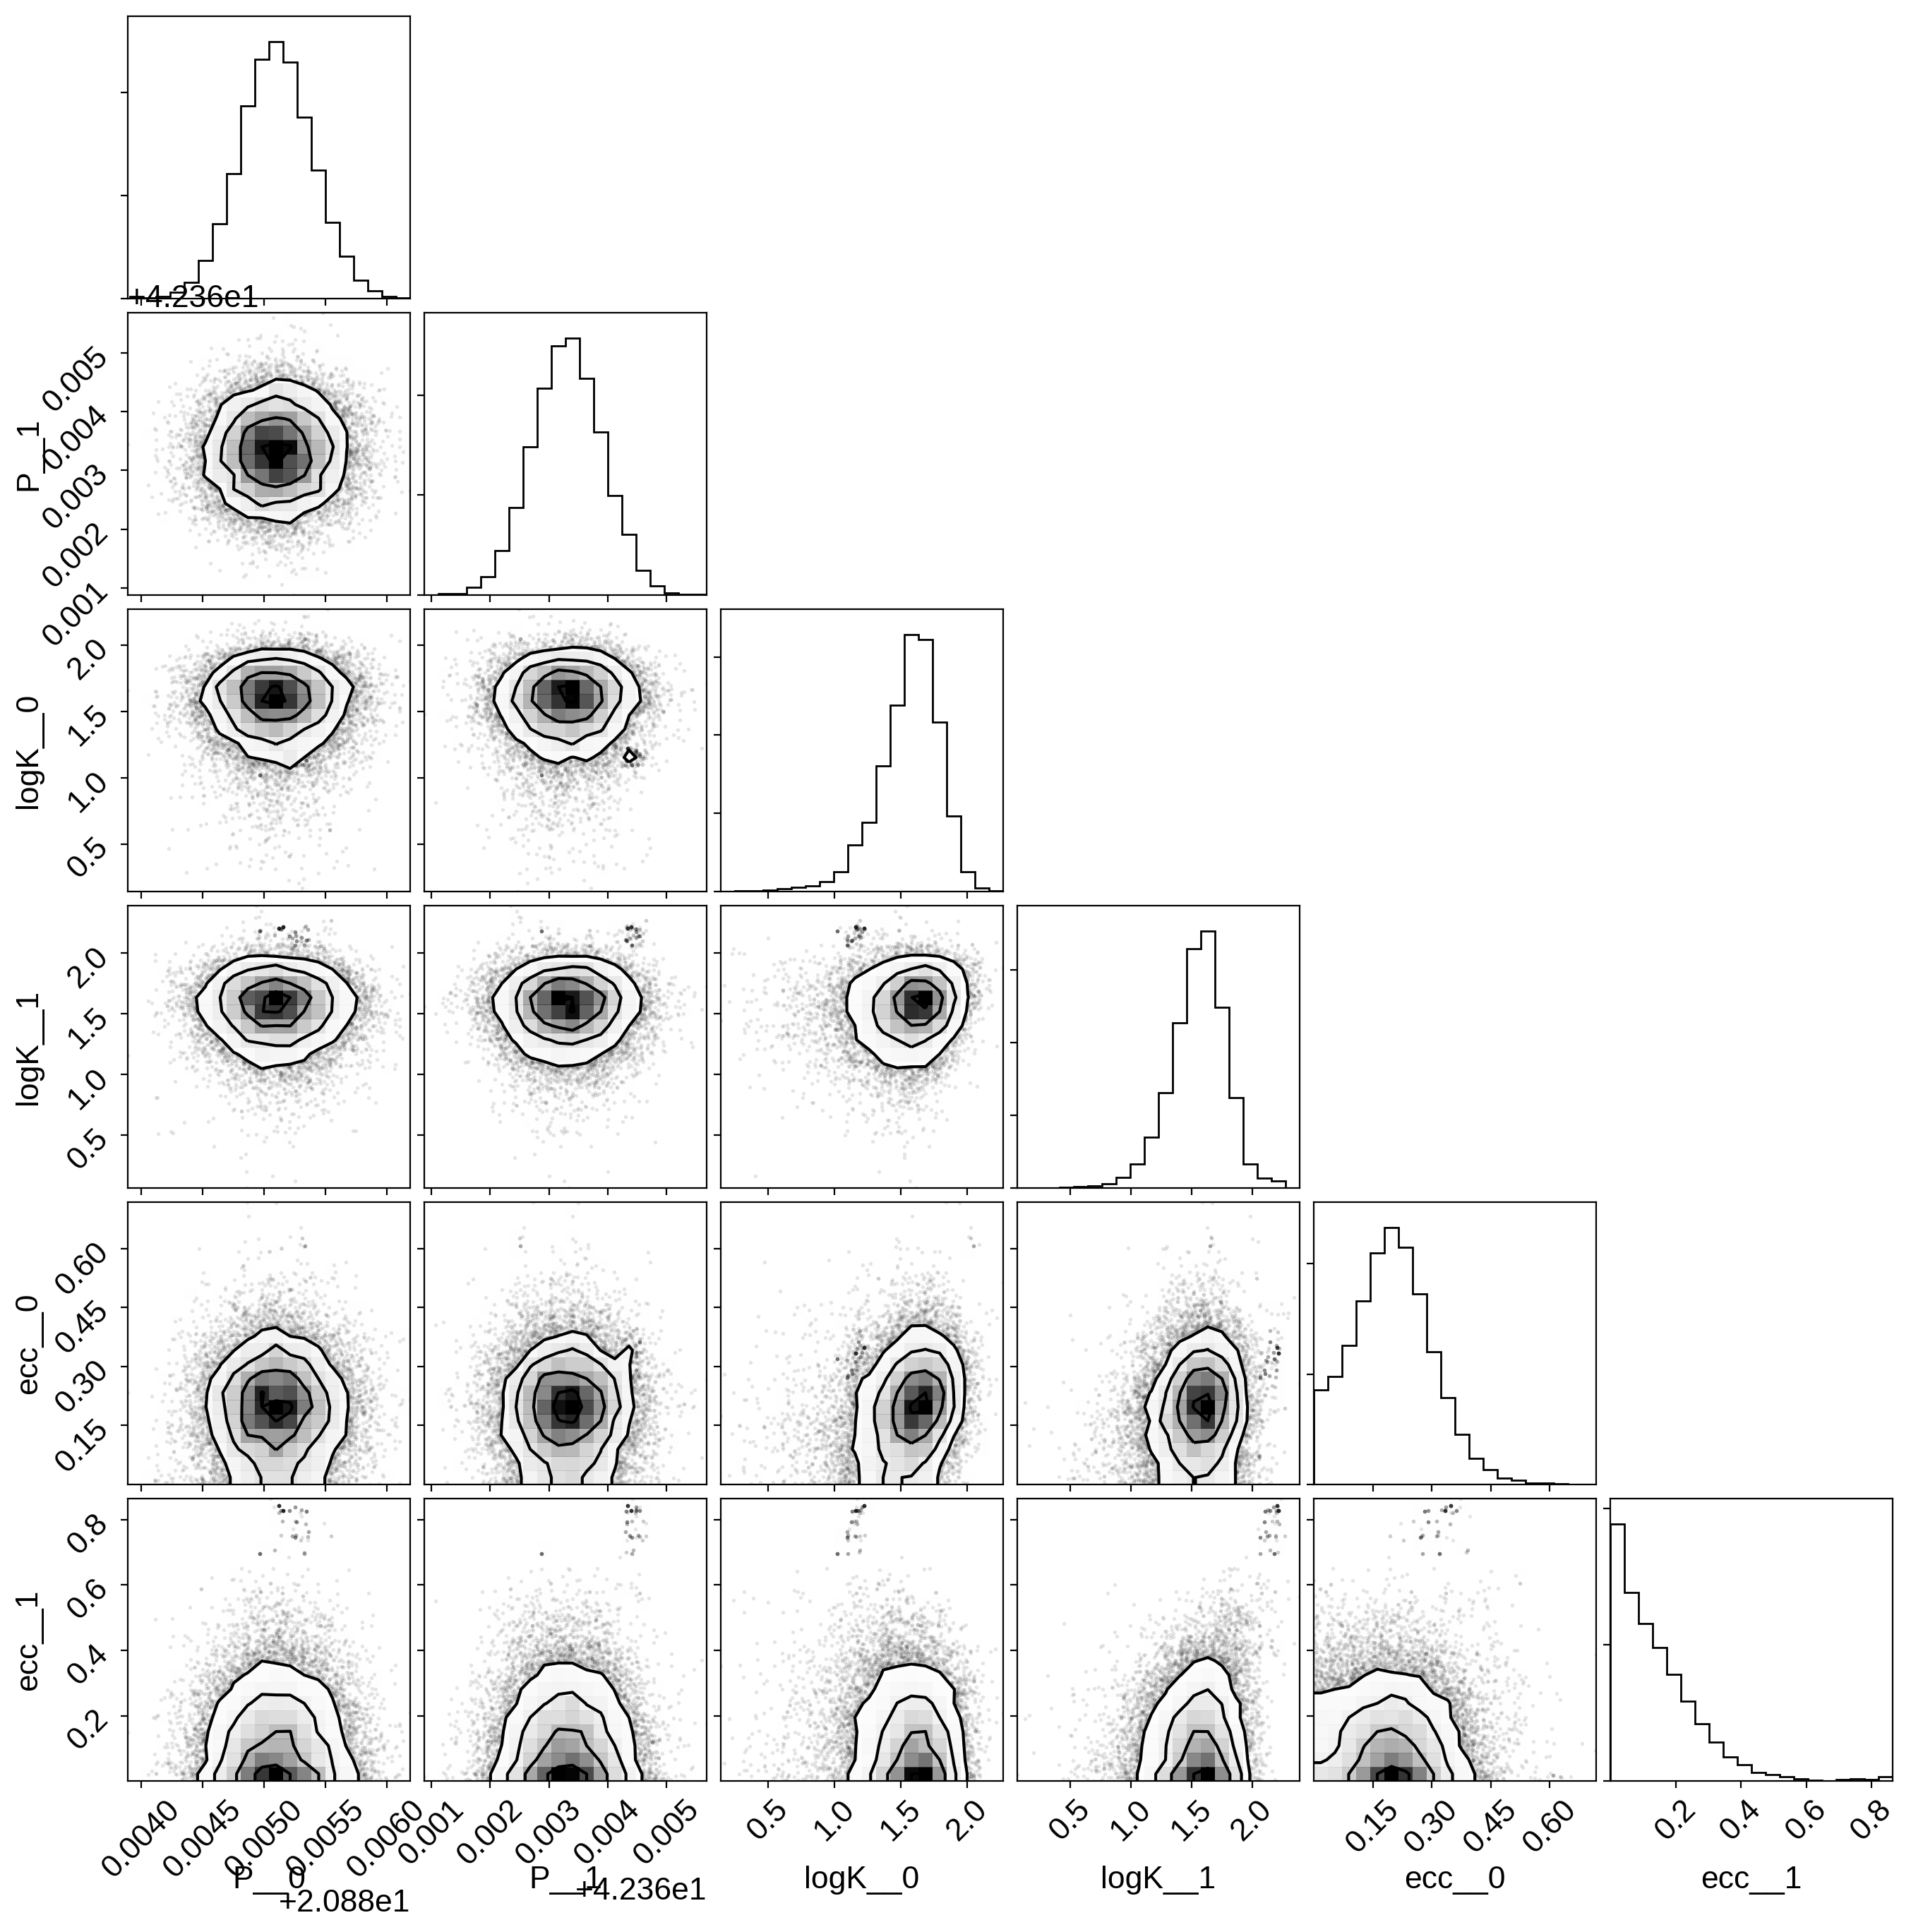

In [13]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=["P", "logK", "ecc"])
corner.corner(samples);

Finally, let's plot the plosterior constraints on the RV model and compare those to the data:

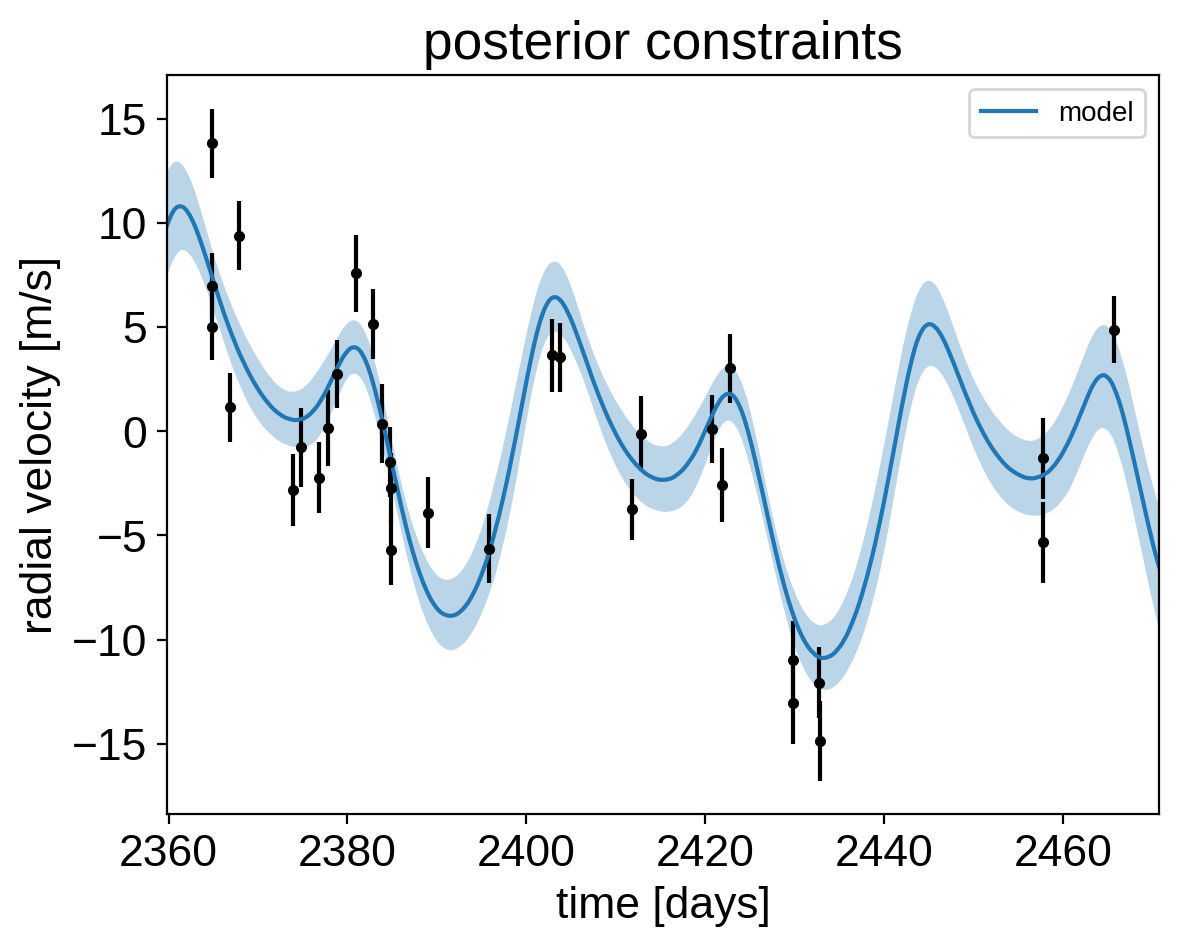

In [14]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

# Compute the posterior predictions for the RV model
pred = np.percentile(trace["rv_model_pred"], [16, 50, 84], axis=0)
plt.plot(t, pred[1], color="C0", label="model")
art = plt.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("posterior constraints");

## Phase plots

It might be also be interesting to look at the phased plots for this system.
Here we'll fold the dataset on the median of posterior period and then overplot the posterior constraint on the folded model orbits.

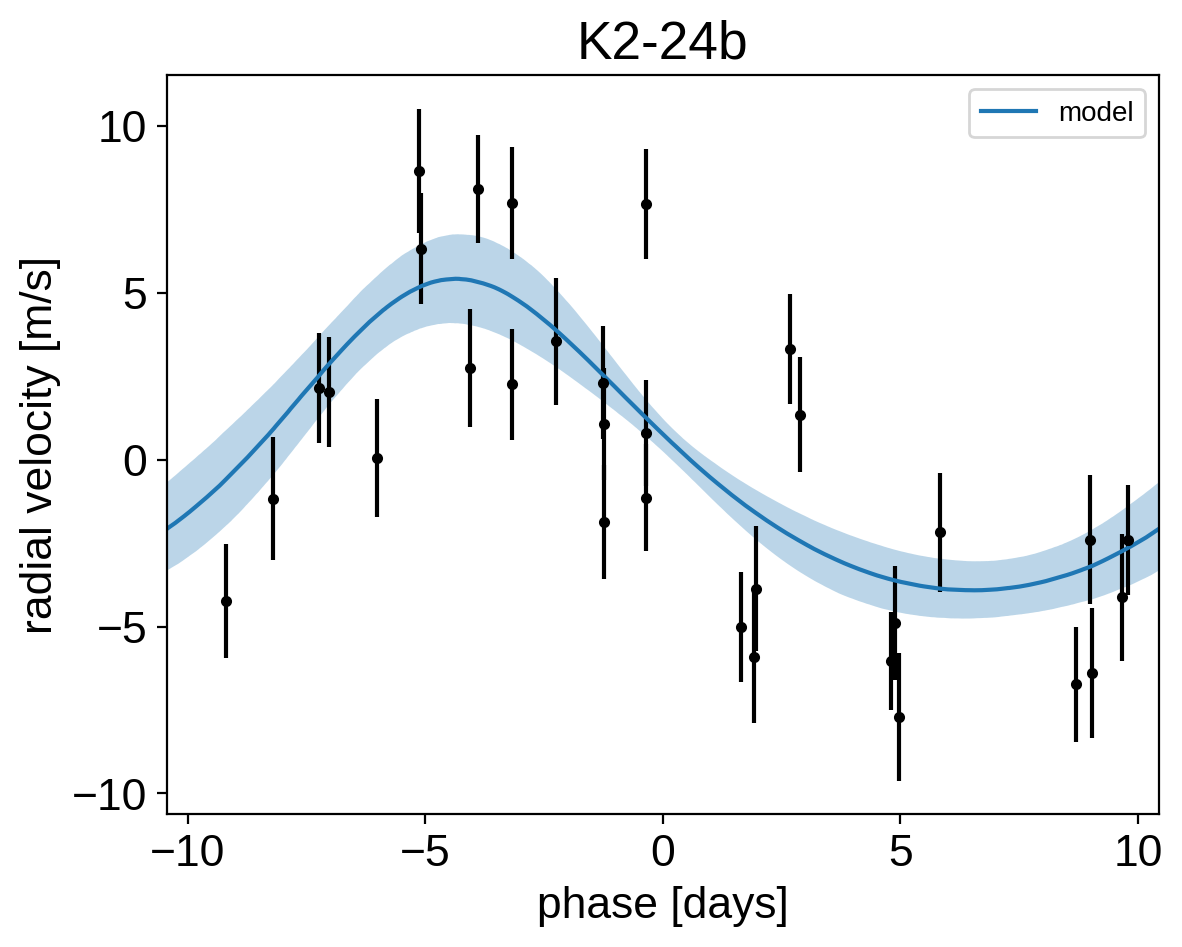

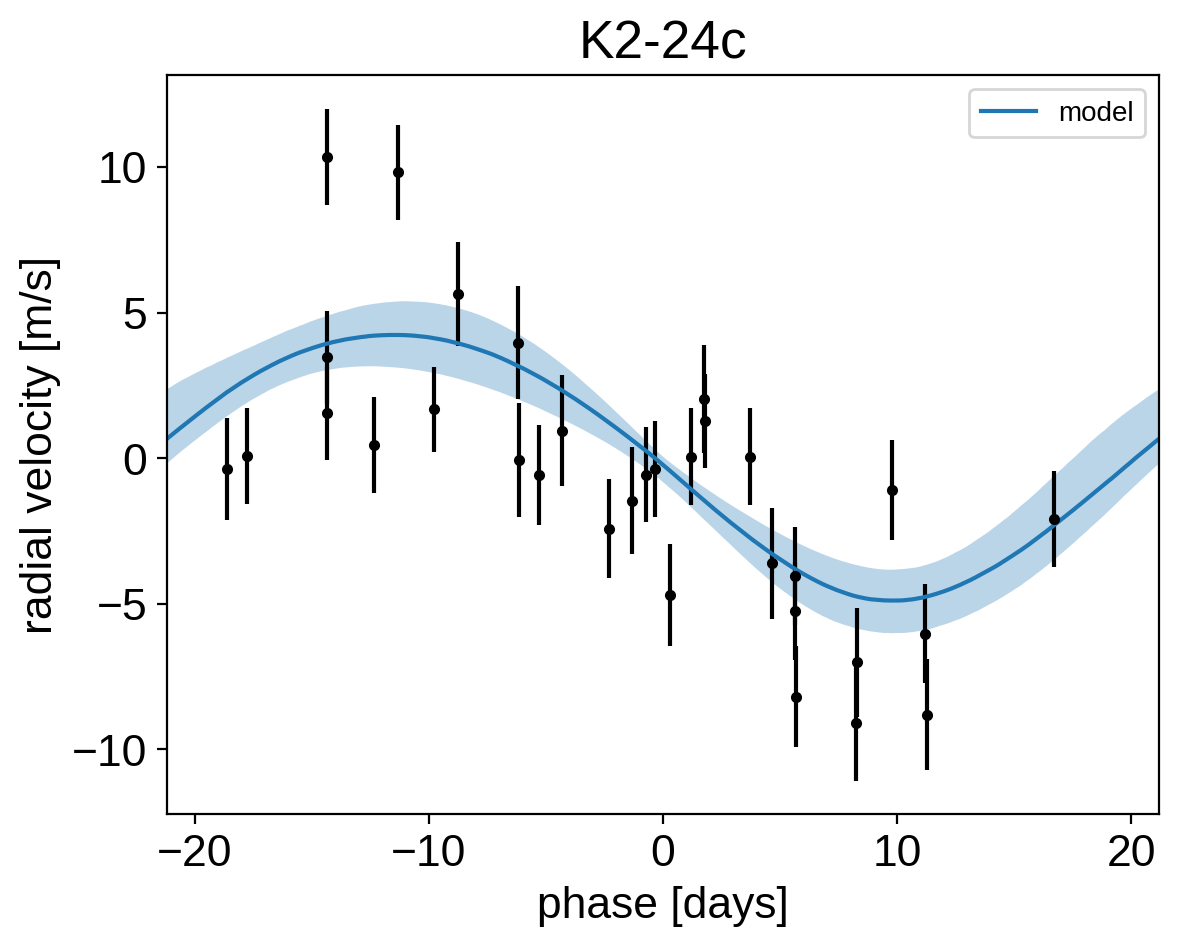

In [15]:
for n, letter in enumerate("bc"):    
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["P"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k")
    
    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t - t0 + 0.5*p) % p - 0.5*p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [16]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:pymc3, exoplanet:theano}.


In [17]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.6},
   month = apr,
    year = 2019,
     doi = {10.5281/zenodo.2651251},
     url = {https://doi.org/10.5281/zenodo.2651251}
...
